# Online Grocery Ordering Project

Online grocery shopping has become much more mainstream since its [bumpy start in 1996](https://streetfins.com/webvan-the-dotcom-bubbles-biggest-bust/). Since the onset of the pandemic, both grocery deliveries *and* curbside-pickup have become even more common. As of August 2023, [most of the largest fifty grocery retailers in the US offer curbside.](https://www.nytimes.com/2020/10/09/business/retailers-curbside-pickup.html#:~:text=Walmart%2C%20with%20about%204%2C700%20stores,with%20a%20focus%20on%20groceries.) 

Even before COVID, grocery-shopping services such as Instacart and Shipt had grown popular. Their shoppers are still a common sight in stores today and many grocery chains even use Shipt (Target) and Instacart (Costco, Publix, Safeway/Tom Thumb/Randall's, Wegmans, and Sprouts) for their delivery orders. However, many of the largest chains now operate their own delivery services in addition to curbside-pickup, such as Walmart, Amazon, Kroger, ALDI, and HEB. 

Recently, Instacart has faced challenges with [more competition and the decline of pandemic-era grocery shopping order frequency,](https://www.winsightgrocerybusiness.com/technology/instacart-faces-big-challenges-ipo-advances#:~:text=Instacart%20faces%20greater%20competition%20from,own%20mobile%20apps%20for%20delivery.) while evolving to contend with [unpredictable restocking issues](https://www.instacart.com/company/how-its-made/how-instacarts-item-availability-evolved-over-the-pandemic/#:~:text=Postface,challenge%20for%20companies%20like%20Instacart.). 

## Instacart dataset
In 2017, Instacart [held a competition on Kaggle.com](https://www.kaggle.com/datasets/yasserh/instacart-online-grocery-basket-analysis-dataset) with an anonymized dataset containing over three million order records. This data is held in six seperate Excel spreadsheets, five of which I combine into a SQLite database below. The total size of the data used here is just over 122.16 MB. 

This data shows information regarding orders, product details, whether the product constituted a new item for the user or a reorder, how often orders were placed, the order's day-of-week and time-of-day, and even the sequence in which each product was placed in the online cart. 

## Project goals

Now, in 2023, with grocery chains' increased in-house delivery & curbside, along with the fact that they exert at least some control over restocking as opposed to Instacart, this dataset may help these grocers manage inventory in addition to informing marketing strategies. 

Specifically, this project uses this dataset to make some preliminary observations and then apply linear regression to specify those findings. The goals of this project are to **present three business recommendations over which aspects of the Instacart data have the most significant correlations with popular, reordered grocery products.** 

I then apply those correlations to **promote new or infrequently purchased products.** These correlations may also help inform:
- restocking 
- ways to simplify reordering 
- predictions of future orders


## Loading in the original data and constructing a SQLite3 database

In [1]:
import pandas as pd
import sqlite3
#Creating the database
conn = sqlite3.connect('instacart.db')

In [2]:
#Reading in each csv file and then converting them to a database table. A few smaller files
# can be read-in together:

#df = pd.read_csv('aisles.csv')
#df.to_sql('aisles', conn)

#df = pd.read_csv('departments.csv')
#df.to_sql('departments', conn)

#df = pd.read_csv('products.csv')
#df.to_sql('products', conn)

In [3]:
#Processing the larger csv's one at a time:

#df = pd.read_csv('orders.csv')
#df.to_sql('orders', conn)

In [4]:
#df = pd.read_csv('order_products__prior.csv')
#df.to_sql('order_products__prior', conn)

In [5]:
#df = pd.read_csv('order_products__train.csv')
#df.to_sql('order_products__train', conn)

In [6]:
#Verifying tables & queries will work:
pd.read_sql("""SELECT * FROM orders LIMIT 5;""", conn)

,index,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,0,2539329,1,prior,1,2,8,NaN
1,1,2398795,1,prior,2,3,7,15.0
2,2,473747,1,prior,3,3,12,21.0
3,3,2254736,1,prior,4,4,7,29.0
4,4,431534,1,prior,5,4,15,28.0


## Preliminary EDA: understanding each database table

Now that everything is in place, let's perform some preliminary EDA to understand what each table contains.

In [7]:
#Making sure each table loaded in
pd.read_sql("""SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name;""", conn)

,name
0,aisles
1,departments
2,order_products__prior
3,order_products__train
4,orders
5,products


In [8]:
#Looking through tables to see the columns they contain, get a sense of 
# what they represent, and check for NaN's or placeholders.
products_df = pd.read_sql("""SELECT * FROM products;""", conn)
products_df

,index,product_id,product_name,aisle_id,department_id
0,0,1,Chocolate Sandwich Cookies,61,19
1,1,2,All-Seasons Salt,104,13
2,2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,4,5,Green Chile Anytime Sauce,5,13
...,...,...,...,...,...
49683,49683,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5
49684,49684,49685,En Croute Roast Hazelnut Cranberry,42,1
49685,49685,49686,Artisan Baguette,112,3
49686,49686,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8


In [9]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   index          49688 non-null  int64 
 1   product_id     49688 non-null  int64 
 2   product_name   49688 non-null  object
 3   aisle_id       49688 non-null  int64 
 4   department_id  49688 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 1.9+ MB


In [10]:
aisles = pd.read_sql("""SELECT * FROM aisles;""", conn)
aisles

,index,aisle_id,aisle
0,0,1,prepared soups salads
1,1,2,specialty cheeses
2,2,3,energy granola bars
3,3,4,instant foods
4,4,5,marinades meat preparation
...,...,...,...
129,129,130,hot cereal pancake mixes
130,130,131,dry pasta
131,131,132,beauty
132,132,133,muscles joints pain relief


In [11]:
departments = pd.read_sql("""SELECT * FROM departments;""", conn)
departments

,index,department_id,department
0,0,1,frozen
1,1,2,other
2,2,3,bakery
3,3,4,produce
4,4,5,alcohol
5,5,6,international
6,6,7,beverages
7,7,8,pets
8,8,9,dry goods pasta
9,9,10,bulk


Looks like we have some NaN's listed as 'missing' at the end of the departments table. We'll deal with those below once we initialize more specific, query-based DataFrames from this database.

In [12]:
order_products__prior_df = pd.read_sql("""SELECT * FROM order_products__prior LIMIT 100;""", conn)
order_products__prior_df

,index,order_id,product_id,add_to_cart_order,reordered
0,0,2,33120,1,1
1,1,2,28985,2,1
2,2,2,9327,3,0
3,3,2,45918,4,1
4,4,2,30035,5,0
...,...,...,...,...,...
95,95,11,1313,4,1
96,96,11,31506,5,1
97,97,12,30597,1,1
98,98,12,15221,2,1


## Continuing with more in-depth EDA: analyzing the products table

In [13]:
product_info_df = pd.read_sql(
                """SELECT
                    order_products__prior.product_id,
                    COUNT(product_id) AS times_ordered,
                    products.product_name,
                    products.department_id,
                    departments.department AS dept_name,
                    products.aisle_id,
                    aisles.aisle AS aisle_name
                FROM order_products__prior
                JOIN products
                    USING(product_id)
                JOIN aisles
                    USING(aisle_id)
                JOIN departments
                    USING(department_id)
                GROUP BY product_id
                ORDER by times_ordered DESC;
                """, conn)
product_info_df.head()

,product_id,times_ordered,product_name,department_id,dept_name,aisle_id,aisle_name
0,24852,15450,Banana,4,produce,24,fresh fruits
1,13176,12409,Bag of Organic Bananas,4,produce,24,fresh fruits
2,21137,8528,Organic Strawberries,4,produce,24,fresh fruits
3,21903,7852,Organic Baby Spinach,4,produce,123,packaged vegetables fruits
4,47209,6857,Organic Hass Avocado,4,produce,24,fresh fruits


Now that we have a DataFrame to work with and some string columns, let's contend with the missing departments (which are accompanied by 'missing' aisles):

In [14]:
missing_departments_and_aisles = product_info_df.loc[product_info_df['dept_name'].isin(['None', 'none', 'missing', 'NaN', 'n/a'])]
missing_departments_and_aisles

,product_id,times_ordered,product_name,department_id,dept_name,aisle_id,aisle_name
667,41149,252,Organic Riced Cauliflower,21,missing,100,missing
2521,14010,74,Organic Mango Yogurt,21,missing,100,missing
2741,7035,68,Peanut Butter Ice Cream Cup,21,missing,100,missing
2939,38510,62,Organic Celery Bunch,21,missing,100,missing
2940,38452,62,Organic Whole Milk Washington Black Cherry Yogurt,21,missing,100,missing
...,...,...,...,...,...,...,...
35338,690,1,Vegetable Hearty Garden Soup,21,missing,100,missing
35378,491,1,Pompelmo Water,21,missing,100,missing
35384,440,1,Crossovers Olive Thyme Almond,21,missing,100,missing
35404,297,1,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",21,missing,100,missing


In [15]:
#How many products are here in thie grouped-by-product df of orders?
len(product_info_df)

35449

In [16]:
#What percent of these records have missing department information?
len(missing_departments_and_aisles)/len(product_info_df)

0.014161189314226072

Hmm, 1.4 percent of the product_info_df isn't a lot and going through 502 records to add those values in doesn't seem like a good use of time for anyone. Additionally, while adding the department in wouldn't be too difficult to intuit (there are only twenty departments), adding the aisle information would be more cumbersome (134 aisles to choose from!). 

However, it looks like some products with missing departments were only ordered once; they're probably not going to be ordered again too often. However, "Organic Riced Cauliflower" makes up 252 orders. Subsequently, I'll just add department/aisle info in for some of the most popular items. Let's see how many missing-department products were ordered over 50 times:

In [17]:
missing_departments_and_aisles[missing_departments_and_aisles['times_ordered'] > 50]

,product_id,times_ordered,product_name,department_id,dept_name,aisle_id,aisle_name
667,41149,252,Organic Riced Cauliflower,21,missing,100,missing
2521,14010,74,Organic Mango Yogurt,21,missing,100,missing
2741,7035,68,Peanut Butter Ice Cream Cup,21,missing,100,missing
2939,38510,62,Organic Celery Bunch,21,missing,100,missing
2940,38452,62,Organic Whole Milk Washington Black Cherry Yogurt,21,missing,100,missing


Okay, this is a managable amount and manually adding their department & aisle data back in may prove helpful since they're at least somewhat popular items. Below, I find which department/aisle they'd belong in using a str.contains() method. For concision purposes, I comment that out and then use a technique I found [here](https://stackoverflow.com/questions/19226488/change-one-value-based-on-another-value-in-pandas) to add in the missing dept/aisle info for these five more popular records:

In [18]:
#product_info_df[product_info_df['product_name'].str.contains('Cauliflower')]
#Ok, the cauliflower one goes in the 'fresh vegetables' isle:
product_info_df.loc[product_info_df['product_name'] == 'Organic Riced Cauliflower', 'dept_name'] = 'produce'
product_info_df.loc[product_info_df['product_name'] == 'Organic Riced Cauliflower', 'aisle_name'] = 'fresh vegetables'
#product_info_df[product_info_df['product_name'].str.contains('Yogurt')]
#This aisle will be 'yogurt':
product_info_df.loc[product_info_df['product_name'] == 'Organic Mango Yogurt', 'dept_name'] = 'dairy eggs'
product_info_df.loc[product_info_df['product_name'] == 'Organic Mango Yogurt', 'aisle_name'] = 'yogurt'
#product_info_df[product_info_df['product_name'].str.contains('Ice Cream')]
#This department will be 'frozen' and its aisle will be 'ice cream ice':
product_info_df.loc[product_info_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'dept_name'] = 'frozen'
product_info_df.loc[product_info_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'aisle_name'] = 'ice cream ice'
#product_info_df[product_info_df['product_name'].str.contains('Celery Bunch')]
#This is in the 'fresh vegetables' aisle:
product_info_df.loc[product_info_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'
product_info_df.loc[product_info_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'
#This last one is another yogurt product:
product_info_df.loc[product_info_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'dept_name'] = 'dairy eggs'
product_info_df.loc[product_info_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'aisle_name'] = 'yogurt'

With those more significant records salvaged, we can drop the remaining (and less significant) missing ones:

In [19]:
product_info_df = product_info_df[product_info_df['dept_name'] != 'missing']
#The df should have 34,952 records (the original length of 35,449 minus the 497 remaining missing ones).
len(product_info_df)

34952

## Deeper EDA: looking for patterns and relationships among the data

### Exploring the products in the database

Let's start grasping the big picture when it comes to these 34,952 unique products. Perhaps a good place to start is the most popular 100:

In [20]:
#Avoiding unnecessary Pandas' subframe copy warnings
pd.options.mode.chained_assignment = None
#Taking the top 100 products and dropping irrelevant columns
top_100_products = product_info_df[0:100]
top_100_products.drop(['product_id', 'department_id', 'aisle_id', 'aisle_name'], axis=1, inplace=True)
top_100_products.sort_values('times_ordered',inplace=True)

In [21]:
cols = ['product_name', 'times_ordered']
top_100_products = top_100_products[cols]

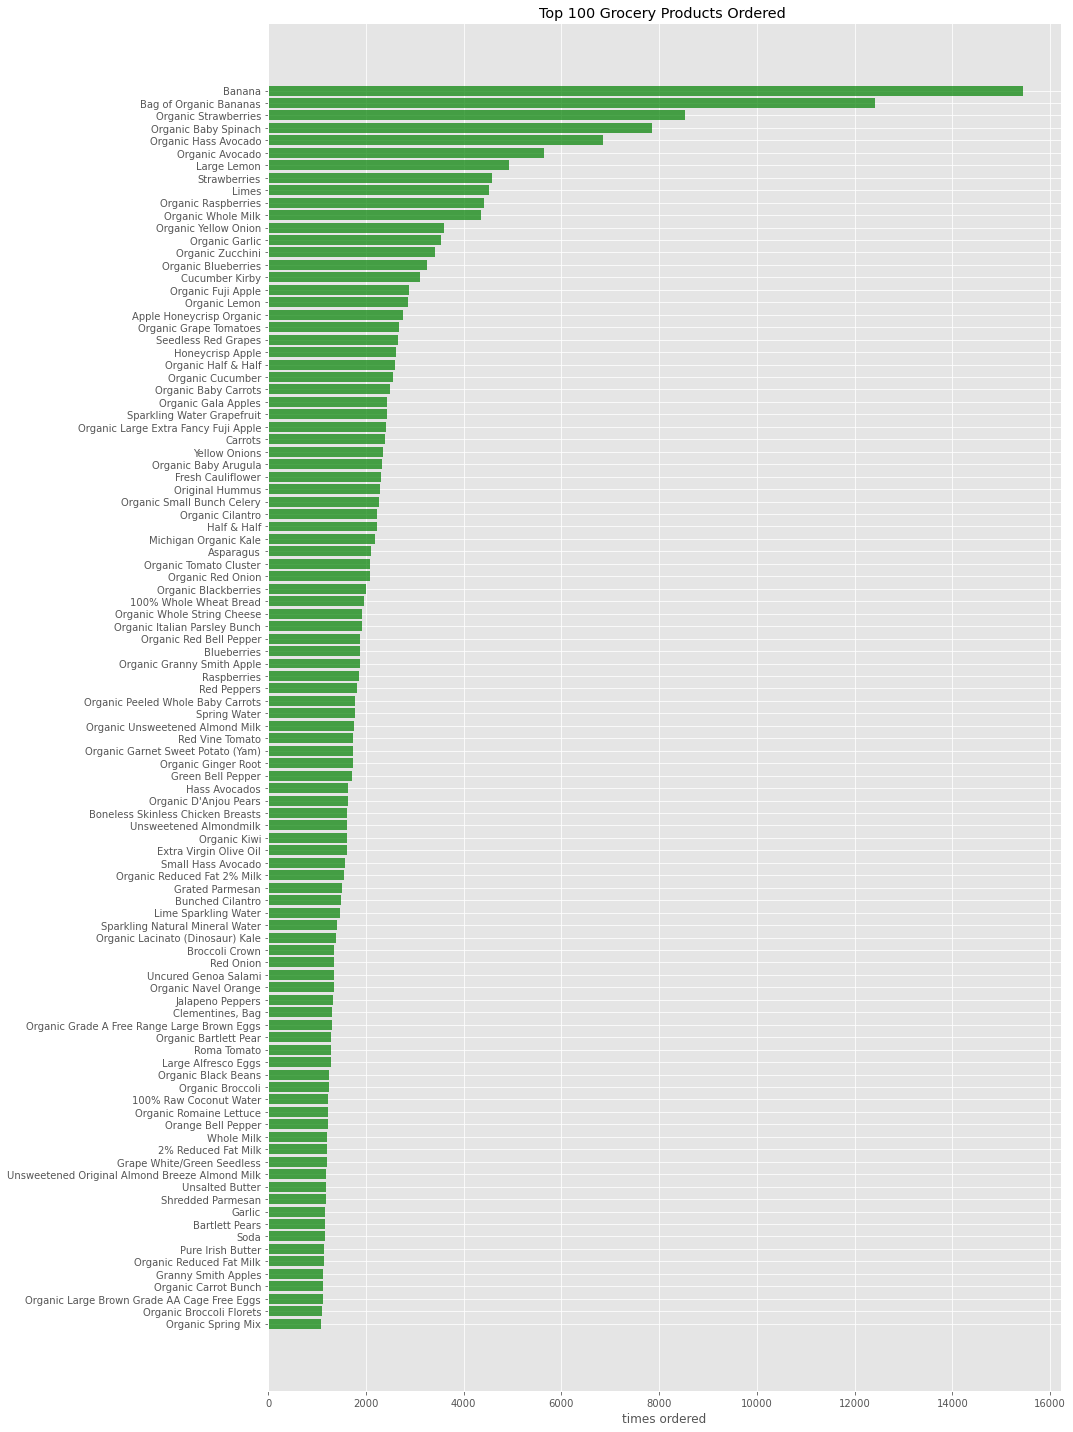

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
#Visualizing this list to see how they compare
fig, ax = plt.subplots(figsize=(15,20))
ax.barh(top_100_products['product_name'], top_100_products['times_ordered'], color='g', alpha=0.7)
ax.set_title('Top 100 Grocery Products Ordered ')
ax.set_xlabel('times ordered')
plt.tight_layout();

Wow, produce - especially fruit - is *dominating* the top grocery products here. Bananas alone are in their own category. There are also plenty of dairy products, a couple bread items, and some sparkling waters here. In any case, I suppose it's no wonder that the produce section has a decent amount of real estate to itself in a store. 

### Looking into the products' departments

Speaking of gorcery departments, let's see how all prior orders break down by department and whether produce is in fact the top seller overall:

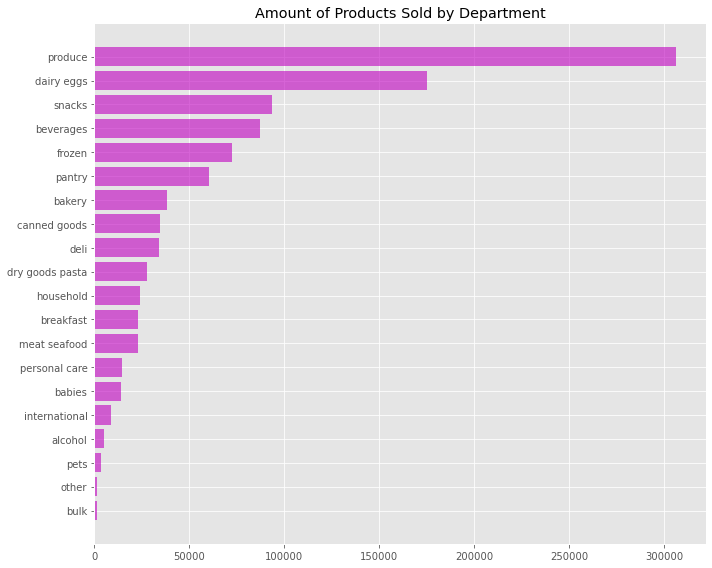

In [23]:
#Grouping the products_df by produce and showing how many times they've been ordered:
product_orders_by_dept = product_info_df.groupby(['dept_name']).sum('times_ordered').sort_values('times_ordered')
product_orders_by_dept.drop(['product_id', 'department_id', 'aisle_id'], axis=1, inplace=True)
#Plotting that information:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(product_orders_by_dept.index, product_orders_by_dept['times_ordered'], color='m', alpha=0.6)
ax.set_title('Amount of Products Sold by Department')
plt.tight_layout()
plt.savefig('Amount_of_Products_Sold_by_Department.png');

This seems to more-or-less align with our top 100 products, although I didn't expect snacks to make such a strong showing. However, let's make sure we're comparing apples-to-apples (grocery pun!) and look at the size of these departments (in this case, 'size' is measured by the variety of products):

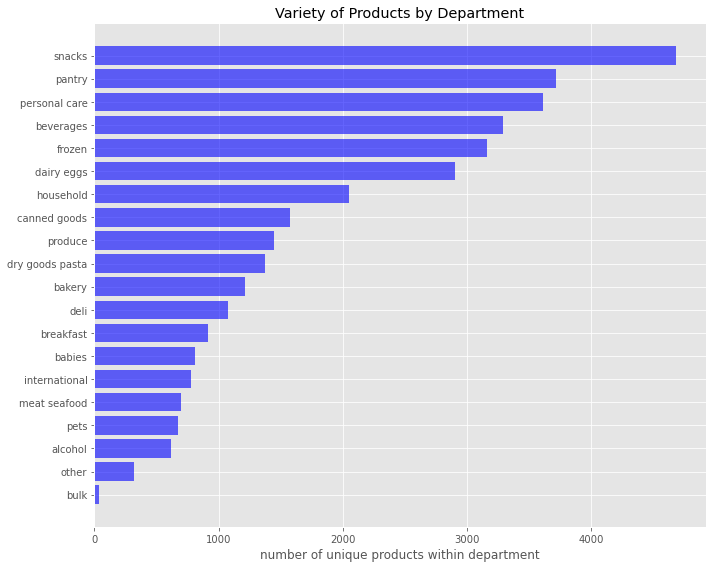

In [24]:
#Subframe:
product_variety_by_dept = product_info_df.groupby(['dept_name']).size().sort_values()
#Plotting:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(product_variety_by_dept.index, product_variety_by_dept.values, color='b', alpha=0.6)
ax.set_title('Variety of Products by Department')
ax.set_xlabel('number of unique products within department')
plt.savefig('Variety_of_Products_by_Department.png')
plt.tight_layout();

Interesting to see how far down the produce department is regarding the variety of its products while maintaining the top spot in number of products sold. The average space taken up by each produce item is likely greater than each snack or pantry item's shelf space (the pantry department has the second-highest variety count, yet comes in sixth place with products sold). Also, produce's relatively smaller variety makes sense when we think about how much more often the produce section undergoes restocking with perishable items; scrutinizing variety here may help reduce waste. 

### Exploring the aisles table

Now that we have an overall picture of product and department popularity to keep in mind as we move forward, let's also explore how the aisles relate. Since Instacart - as a grocery *retrieval service*, not a grocer - would want to optimize its workers' shopping trips, aisle order and/or position may be important. The provided 'aisles' table *might* represent a specific store, but it probably refers to a generalized aisle layout, or just some helpful placeholders for sub-department classifications. 

It may be the latter since, as seen previously, there are 134 aisles listed in that table, which seems much larger than even a large grocery store. Additionally, Instacart is likely interested in a broader look at their order data beyond that of a single store. 

In [25]:
product_orders_by_aisle = product_info_df.loc[:, ['aisle_id', 'aisle_name', 'dept_name', 'times_ordered']]
product_orders_by_aisle.groupby(['aisle_id', 'aisle_name']).sum('times_ordered').sort_values('aisle_id')

,,times_ordered
aisle_id,aisle_name,
1,prepared soups salads,2372
2,specialty cheeses,2718
3,energy granola bars,14811
4,instant foods,6380
5,marinades meat preparation,1935
...,...,...
130,hot cereal pancake mixes,5244
131,dry pasta,8547
132,beauty,174


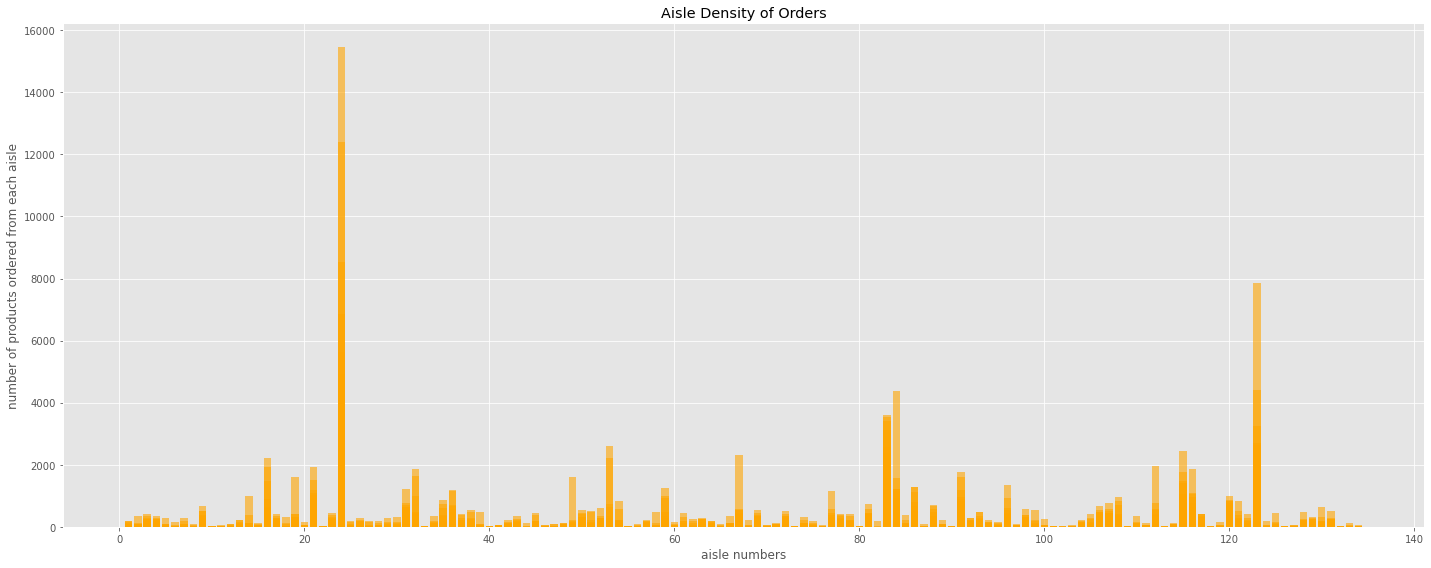

In [26]:
#Plotting the density of each aisle (this can take a minute to load):
fig, ax = plt.subplots(figsize=(20,8))
ax.bar(product_orders_by_aisle['aisle_id'], product_orders_by_aisle['times_ordered'], color='orange', alpha=0.6)
ax.set_title('Aisle Density of Orders')
ax.set_xlabel('aisle numbers')
ax.set_ylabel('number of products ordered from each aisle')
plt.tight_layout();

Assuming a more-or-less straight-line path through the store, shoppers (whether customers or delivery/curbside employees) may encounter quite the busy 24th aisle, but the rest are likely managable except for a few more dense aisles along the way. 

Of course, we know stores aren't laid out this way. There's usually an entire produce section, a 'meat market' section with butcher and deli counters (neither of which have an assigned 'aisle number'), a bakery section/counter, and likely a large variety of layouts for numbered aisles. Some stores are smaller and barely sell anything that isn't a food product, while others have clothing aisles and [you can even buy a truck at Costco](https://www.businessinsider.com/costco-car-buying-program-vs-buying-at-a-dealership-2018-3). 

Ultimately, this graph may not prove too useful to Instacart, but it may be insightful for grocery stores when setting up new stores or reorganizing existing layouts. Of course, product-popularity-by-aisle has doubtlessly been accounted for and may be part of the reason why produce has its own 'section' where the (often unnumbered) 'aisles' are wider. The popularity of the 'dairy egg' department may be part of the reason that [milk is usually found towards the back of the store](https://www.tasteofhome.com/article/the-real-reason-your-grocery-store-milk-gets-put-in-the-back/#:~:text=It%20turns%20out%20that%20supermarkets,to%20food%20writer%20Michael%20Pollan.) alongside with its proximity to the loading docks.

### Which products are reordered more often?

In any case, we've been looking at products in general so far. Let's also explore the provided data on which products tend to be *reordered*:

In [27]:
product_reorders_df = pd.read_sql(
                        """SELECT
                                opp.product_id,
                                p.product_name,
                                COUNT(opp.product_id) AS times_ordered,
                                SUM(opp.reordered) as times_reordered, 
                                AVG(opp.add_to_cart_order) AS avg_place_in_added_to_cart_sequence,
                                d.department AS dept_name
                            FROM order_products__prior AS opp
                            JOIN products AS p
                                USING(product_id)
                            JOIN departments AS d
                                USING(department_id)
                            GROUP BY product_id
                            ORDER BY times_reordered DESC;
                        """, conn)
product_reorders_df

,product_id,product_name,times_ordered,times_reordered,avg_place_in_added_to_cart_sequence,dept_name
0,24852,Banana,15450,13024,4.895793,produce
1,13176,Bag of Organic Bananas,12409,10297,5.114433,produce
2,21137,Organic Strawberries,8528,6603,7.173194,produce
3,21903,Organic Baby Spinach,7852,6093,7.389455,produce
4,47209,Organic Hass Avocado,6857,5435,6.815663,produce
...,...,...,...,...,...,...
35444,38,Ultra Antibacterial Dish Liquid,1,0,12.000000,missing
35445,19,Gluten Free Quinoa Three Cheese & Mushroom Blend,1,0,21.000000,dry goods pasta
35446,14,Fresh Scent Dishwasher Cleaner,2,0,9.500000,household
35447,8,Cut Russet Potatoes Steam N' Mash,2,0,9.500000,frozen


In [28]:
#Reapplying the missing department records from before (aisles don't seem as pertinent any longer):
product_reorders_df.loc[product_reorders_df['product_name'] == 'Organic Riced Cauliflower', 'dept_name'] = 'produce'
product_reorders_df.loc[product_reorders_df['product_name'] == 'Organic Mango Yogurt', 'dept_name'] = 'dairy eggs'
product_reorders_df.loc[product_reorders_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'dept_name'] = 'frozen'
product_reorders_df.loc[product_reorders_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'
product_reorders_df.loc[product_reorders_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'dept_name'] = 'dairy eggs'

#Then dropping the remaining missing departments:
product_reorders_df = product_reorders_df[product_reorders_df['dept_name'] != 'missing']

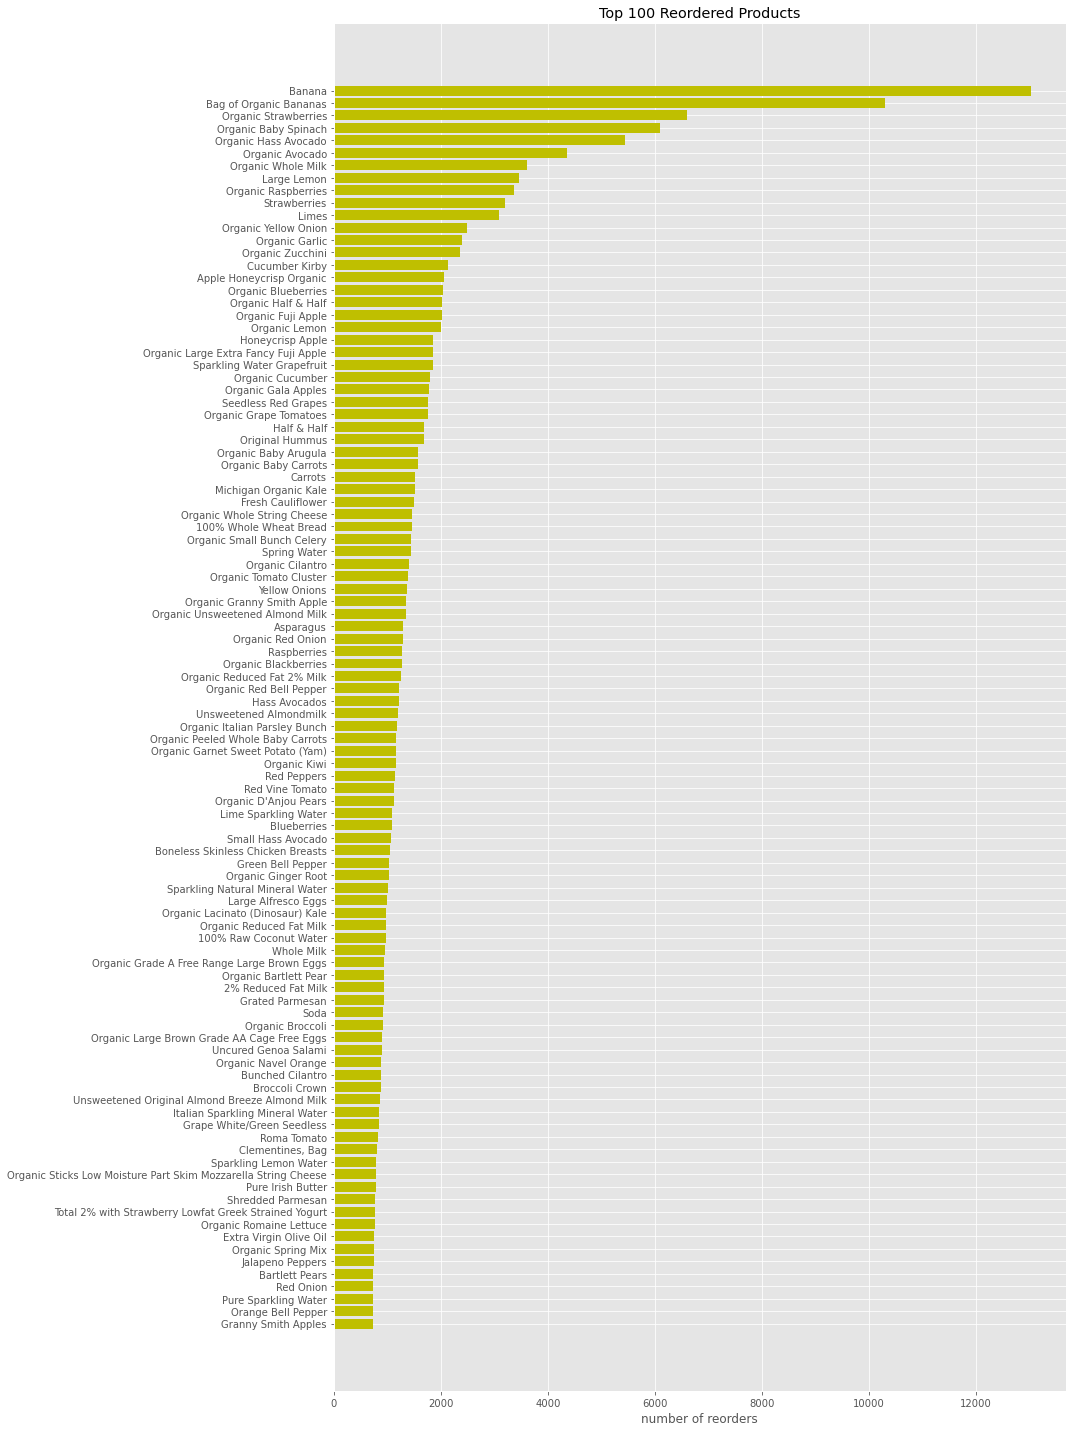

In [29]:
#Looking first at the 100 most frequently reordered products 
top_100_reorders = product_reorders_df[0:100].sort_values('times_reordered')

fig, ax = plt.subplots(figsize=(15,20))
ax.barh(top_100_reorders['product_name'], top_100_reorders['times_reordered'], color='y')
ax.set_title('Top 100 Reordered Products')
ax.set_xlabel('number of reorders')
plt.tight_layout();

We see many similarities with the top 100 overall products. What if we looked at the *percentage* of product orders that are reorders instead of just the overall count?

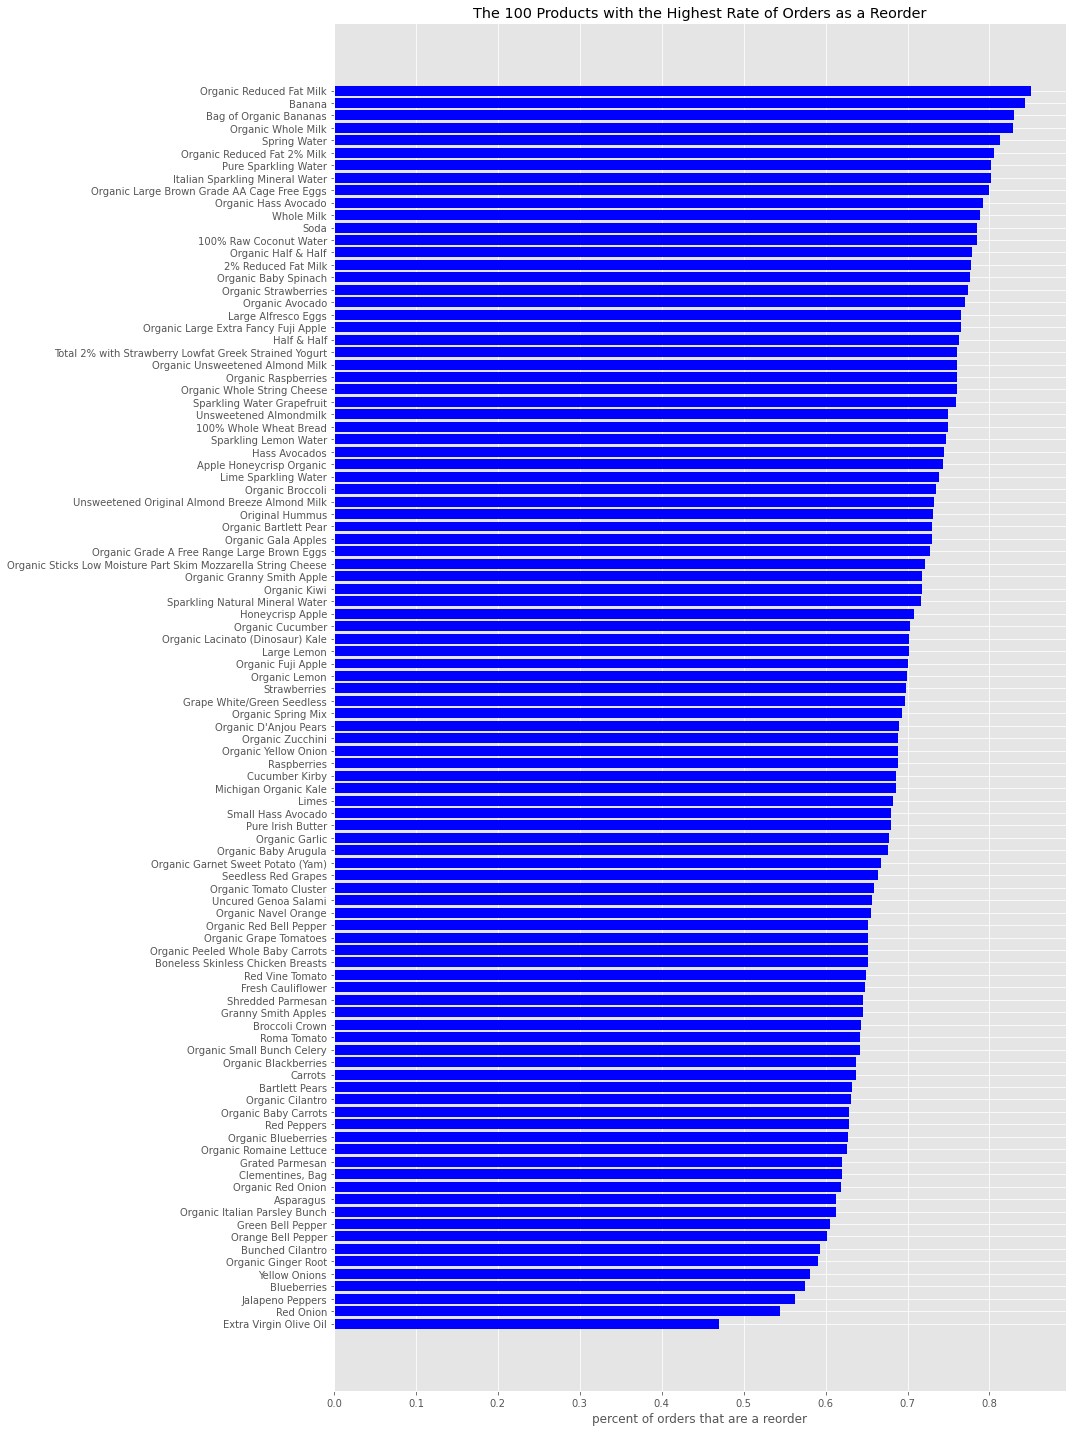

In [30]:
#Adding a percentage reordered column that standardizes how often these products are reordered.
product_reorders_df['percentage_as_a_reorder'] = product_reorders_df['times_reordered'] / product_reorders_df['times_ordered']
#Isolating the top 100
top_100_reorders_percentages = product_reorders_df[0:100].sort_values('percentage_as_a_reorder')

fig, ax = plt.subplots(figsize=(15,20))
ax.barh(top_100_reorders_percentages['product_name'], top_100_reorders_percentages['percentage_as_a_reorder'], color='b')
ax.set_title('The 100 Products with the Highest Rate of Orders as a Reorder')
ax.set_xlabel('percent of orders that are a reorder')
plt.tight_layout();

There's an interesting resurgance of the 'diary egg' department percentage-wise here. This may have something to do with the relatively short shelf-life of produce and dairy products as opposed to other departments' products.

### Investigating product orders & reorders by department
Let's nail down some specifics for departments when it comes to both reorder counts and percentages. The table below is ordered by highest reorder percentages:

In [31]:
dept_reorders_by_count = product_reorders_df.groupby('dept_name')['times_reordered'].sum()
dept_reorders_by_percent = product_reorders_df.groupby('dept_name')['percentage_as_a_reorder'].mean()

dept_reorders_df = pd.DataFrame(columns = ['dept_reorders_by_count', 'dept_reorders_by_percent'])
dept_reorders_df['dept_reorders_by_count'] = dept_reorders_by_count
dept_reorders_df['dept_reorders_by_percent'] = dept_reorders_by_percent
dept_reorders_df['no_of_unique_products'] = product_variety_by_dept

dept_reorders_df.sort_values('dept_reorders_by_percent', ascending=False)

,dept_reorders_by_count,dept_reorders_by_percent,no_of_unique_products
dept_name,,,
pets,2071,0.590717,670
dairy eggs,117336,0.538598,2907
bakery,24220,0.524813,1215
beverages,56714,0.517102,3294
deli,20630,0.493651,1074
snacks,53943,0.485326,4688
breakfast,12881,0.478369,912
babies,8021,0.474626,810
bulk,659,0.467972,34


Interestingly enough, 'dairy eggs' has the second-highest percentage of orders that are reorders (53.9%) whereas produce is in the middle of the pack at 44.8%. However, it's worth noting that 'dairy eggs' has about twice as many different products than produce. Nonetheless, this suggests that dairy and egg product orders may be more consistent mainstays than produce products;  while produce is ordered more often, the individual produce products may vary more from one order to the next. 

It also seems noteworthy that the 'pets' department has the highest reorder percentage by far. I suppose pet owners know what their animals need and less in the way of variety is needed. Dairy, baked goods, and beverages also seem to cluster somewhat closely as more mainstay-oriented departments. 

### Order frequency: adding products to the cart and when orders are placed

Below, I start by seeing whether the most commonly reordered products tend to be placed in the cart with any sort of pattern and, as we see below, no such pattern emerges just among the top 100 products. 

However, once we take a step back to the a larger picture, we find a more general trend: **the higher the percent of reorders a product has, the more likely it will be added to the cart towards the beginning of the order process.**

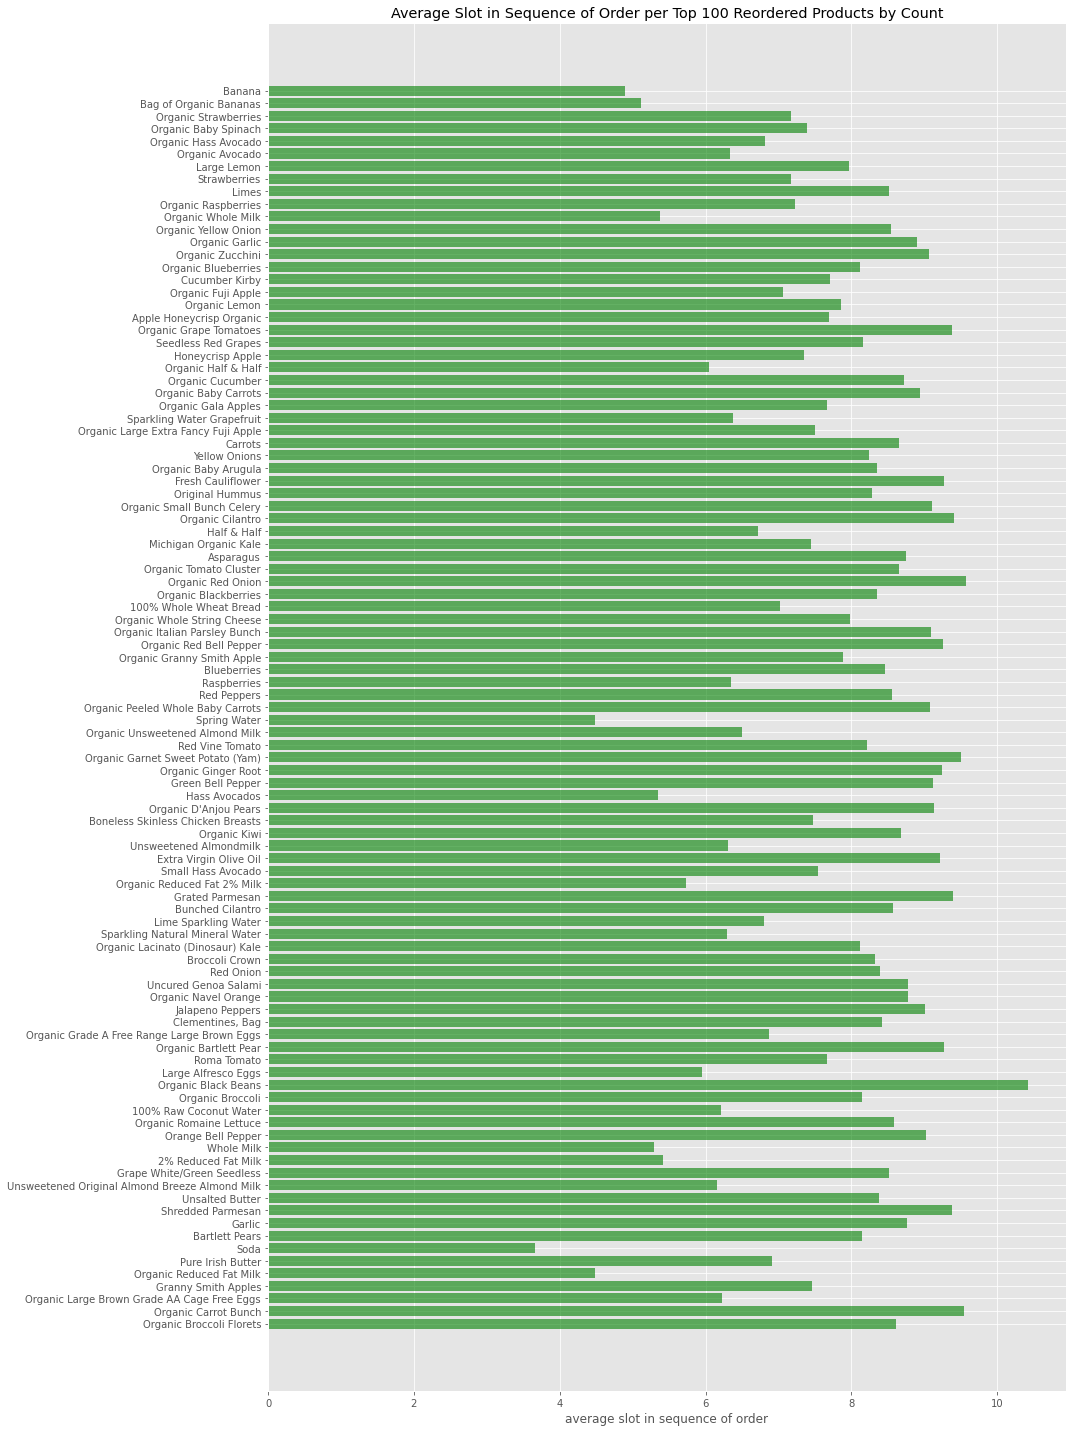

In [32]:
top_100_reorders_by_count = product_reorders_df.sort_values('times_ordered', ascending=False)
top_100_reorders_by_count = top_100_reorders_by_count[0:99]
#Reordering it for the graph:
top_100_reorders_by_count = top_100_reorders_by_count.iloc[::-1]

fig, ax = plt.subplots(figsize=(15,20))
ax.barh(top_100_reorders_by_count['product_name'], top_100_reorders_by_count['avg_place_in_added_to_cart_sequence'], color='g', alpha=0.6)
ax.set_title('Average Slot in Sequence of Order per Top 100 Reordered Products by Count')
ax.set_xlabel('average slot in sequence of order')
plt.tight_layout();

Reordering a product and its place in the sequence of being added to the cart do not appear to be strongly correlated. Let's take another look at this top_100_reorders_by_count df:

In [33]:
#Undoing the previous reordering for the graph:
top_100_reorders_by_count = top_100_reorders_by_count.iloc[::-1]
top_100_reorders_by_count.head(10)

,product_id,product_name,times_ordered,times_reordered,avg_place_in_added_to_cart_sequence,dept_name,percentage_as_a_reorder
0,24852,Banana,15450,13024,4.895793,produce,0.842977
1,13176,Bag of Organic Bananas,12409,10297,5.114433,produce,0.829801
2,21137,Organic Strawberries,8528,6603,7.173194,produce,0.774273
3,21903,Organic Baby Spinach,7852,6093,7.389455,produce,0.775981
4,47209,Organic Hass Avocado,6857,5435,6.815663,produce,0.792621
5,47766,Organic Avocado,5646,4349,6.332625,produce,0.770280
7,47626,Large Lemon,4928,3456,7.961445,produce,0.701299
9,16797,Strawberries,4587,3204,7.163942,produce,0.698496
10,26209,Limes,4526,3086,8.514361,produce,0.681838
8,27966,Organic Raspberries,4420,3361,7.231900,produce,0.760407


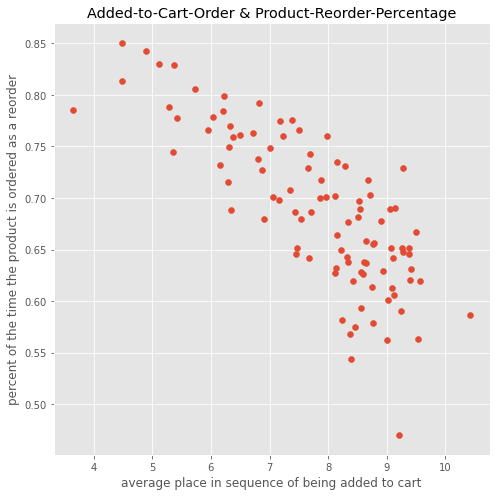

In [34]:
#How about the add-to-cart orders versus their percentage-likelihood-to-be-a-reorder?
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(top_100_reorders_by_count['avg_place_in_added_to_cart_sequence'], top_100_reorders_by_count['percentage_as_a_reorder'])
ax.set_title("Added-to-Cart-Order & Product-Reorder-Percentage")
ax.set_ylabel('percent of the time the product is ordered as a reorder')
ax.set_xlabel('average place in sequence of being added to cart')
plt.savefig("Added-to-Cart-Order & Product-Reorder-Percentage.png")
plt.tight_layout();

There's an apparent negative correlation here: the more likely a product is to be a reorder, the earlier it appears in the cart during the order.

This was the top 100, though. We don't need to limit the number if we're noticing a broader trend, so let's redo this with the whole scope of products:

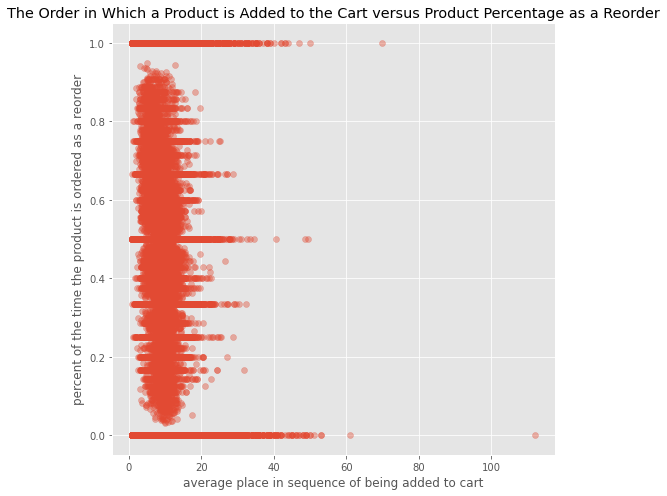

In [35]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(product_reorders_df['avg_place_in_added_to_cart_sequence'], product_reorders_df['percentage_as_a_reorder'], alpha=0.4)
ax.set_title("The Order in Which a Product is Added to the Cart versus Product Percentage as a Reorder")
ax.set_ylabel('percent of the time the product is ordered as a reorder')
ax.set_xlabel('average place in sequence of being added to cart')
plt.tight_layout();

That's a mess. It looks like percentages accumulate in certain places and some outliers make it hard to spot a correlation. Before we dive more extensively into this issue (which I do in the regression analysis portion of this project), let's just make it the top 1,000 reordered products and see what we find:

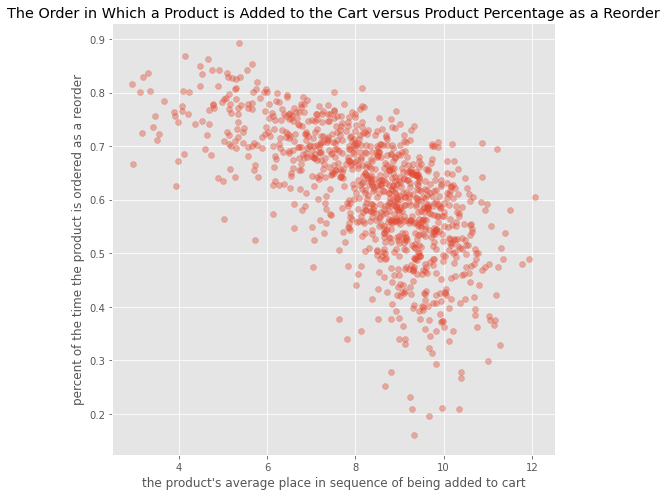

In [36]:
top_1000_reorders_by_count = product_reorders_df.sort_values('times_ordered', ascending=False)
top_1000_reorders_by_count = top_1000_reorders_by_count[0:999]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(top_1000_reorders_by_count['avg_place_in_added_to_cart_sequence'], top_1000_reorders_by_count['percentage_as_a_reorder'], alpha=0.4)
ax.set_title("The Order in Which a Product is Added to the Cart versus Product Percentage as a Reorder")
ax.set_ylabel("percent of the time the product is ordered as a reorder")
ax.set_xlabel("the product's average place in sequence of being added to cart")
plt.tight_layout();

It looks like a similar trend with the top 100 reordered products, but it's taking a curved shape rather than a seemingly straight line now that we're looking at more products. Once we move on to detailing these findings with linear regression, this correlation will likely show up. 

Let's also investigate how orders look when it comes to the day of the week and hour of day:

In [37]:
order_times_df = pd.read_sql(
                    """SELECT
                            products.product_id,
                            products.product_name,
                            orders.order_number,
                            orders.order_dow AS day_of_week,
                            orders.order_hour_of_day,
                            orders.days_since_prior_order,
                            departments.department AS dept_name,
                            aisles.aisle AS aisle_name
                        FROM aisles
                        JOIN products 
                            USING(aisle_id)
                        JOIN departments
                            USING(department_id)
                        JOIN order_products__prior
                            USING(product_id)
                        JOIN orders
                            USING(order_id);
                    """, conn)
order_times_df

,product_id,product_name,order_number,day_of_week,order_hour_of_day,days_since_prior_order,dept_name,aisle_name
0,209,Italian Pasta Salad,26,0,20,1.0,deli,prepared soups salads
1,554,Turkey Chili,12,0,20,4.0,deli,prepared soups salads
2,554,Turkey Chili,2,4,10,1.0,deli,prepared soups salads
3,554,Turkey Chili,7,6,13,6.0,deli,prepared soups salads
4,554,Turkey Chili,45,3,5,4.0,deli,prepared soups salads
...,...,...,...,...,...,...,...,...
1048570,47713,Sparkling Rose,2,4,8,14.0,alcohol,specialty wines champagnes
1048571,47713,Sparkling Rose,2,6,17,6.0,alcohol,specialty wines champagnes
1048572,48984,Dry Sherry,1,4,21,NaN,alcohol,specialty wines champagnes
1048573,48984,Dry Sherry,15,1,19,1.0,alcohol,specialty wines champagnes


In [38]:
order_times_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   product_id              1048575 non-null  int64  
 1   product_name            1048575 non-null  object 
 2   order_number            1048575 non-null  int64  
 3   day_of_week             1048575 non-null  int64  
 4   order_hour_of_day       1048575 non-null  int64  
 5   days_since_prior_order  981545 non-null   float64
 6   dept_name               1048575 non-null  object 
 7   aisle_name              1048575 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 64.0+ MB


Looks like we have some NaN's in the days_since_prior_order column; are they zeroes?

In [39]:
order_times_df['days_since_prior_order'].value_counts()

7.0     112256
30.0     96293
6.0      82568
5.0      68708
4.0      66108
8.0      61782
3.0      61738
2.0      48195
9.0      40523
14.0     34081
10.0     32751
1.0      29976
11.0     27484
13.0     26960
12.0     24864
15.0     21951
16.0     14703
0.0      14443
21.0     13607
17.0     12408
20.0     12280
19.0     11805
18.0     10998
22.0      9384
28.0      8178
23.0      7190
27.0      6476
24.0      6355
25.0      5901
29.0      5897
26.0      5682
Name: days_since_prior_order, dtype: int64

In [40]:
order_times_df['days_since_prior_order'].isna().sum()

67030

As we see in the value_counts above, the null 'days_since_prior_order' values here are not placeholders for '0' days. They actually represent data from the last orders customers made before this dataset snapshot was taken back in 2017. A lot of the data from those records were removed and put into a train-test split for an [Instacart Kaggle competition](https://www.kaggle.com/competitions/instacart-market-basket-analysis/data). Contestants trying to predict future orders trained on the 'order_products__prior' table, tested on the train, but Instacart's team scored contestnats on the test set they kept. 

I'm using this dataset much later on, so for my purposes, I'll just stick with the order_products__prior. I don't think I need to drop the records containing those NaNs so much as keep them in mind once I start working with days_since_prior_order.

In any case, let's begin looking through these order times by isolating the day of the week:

In [41]:
order_times_df['day_of_week'].value_counts()

0    200157
1    182577
6    146549
2    138111
5    135534
3    124116
4    121531
Name: day_of_week, dtype: int64

I'm not sure which day of the week corresponds to 0 and I'm not finding any answers from Instacart's Kaggle data description. I think '0' would typically be Sunday since it's the first day of the week, but my guess is it's Saturday here since '0' and '1' have the most orders by far. Looking online, it seems like [people definitely shop most often on Saturday, then Sunday, then there's a big dropoff to Monday](https://www.creditdonkey.com/grocery-shopping-statistics.html#:~:text=What%20day%20of%20the%20week%20is%20the,Saturdays%20are%20prime%20time%20for%20grocery%20shoppers.), which would correspond with assiging '0' to Saturday here.

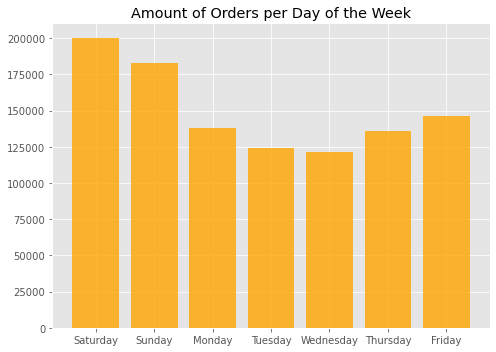

In [42]:
#Grouping the order_times_df
orders_by_dow = order_times_df.groupby('day_of_week').count()
orders_by_dow.reset_index(inplace=True)

#Replacing the numeric day of the week values
day_of_week_dict = {0: 'Saturday', 1: 'Sunday', 2: 'Monday', 3: 'Tuesday', 
                    4: 'Wednesday', 5: 'Thursday', 6: 'Friday'}
orders_by_dow['day_of_week'].replace(day_of_week_dict, inplace=True)

#Plotting
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(orders_by_dow['day_of_week'], orders_by_dow['product_id'], color='orange', alpha=0.8)
ax.set_title("Amount of Orders per Day of the Week")
plt.savefig("Amount of Orders per Day of the Week.png")
plt.tight_layout();

If this is correct, then customers do indeed tend to shop (or at least *order* groceries) on the weekend while Wednesday is the the grocer's least busy day. I wonder whether grocery stores do more restocking, cleaning, or other administrative stuff on those days. Maybe Tuesday and Wednesday make up the average grocery worker's "weekend". Anyway, there's definitely a "ramp-up" to the weekend that begins on Thursday.

Let's see what insights we may find regarding hour-of-day patterns:

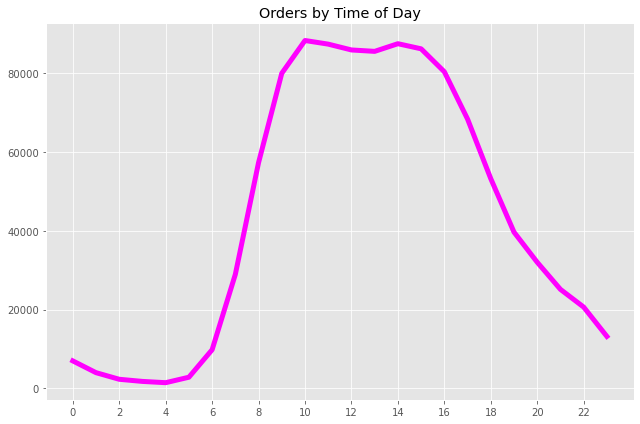

In [43]:
orders_by_hod = order_times_df.groupby('order_hour_of_day').count()

import numpy as np
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(orders_by_hod.index, orders_by_hod['product_id'], color='magenta', lw=5)
ax.set_title("Orders by Time of Day")
plt.xticks(ticks=np.arange(0,24,2))
plt.tight_layout();

Orders seem to remain pretty consistent between 10am-3pm before falling off for the night. It'd be interesting to have data on turn-around time for these orders, but either way, grocery-ordering seems to be a pretty diurnal phenomenon.

The last of the big-picture time perspectives offered here is the amount of days since the last order. 

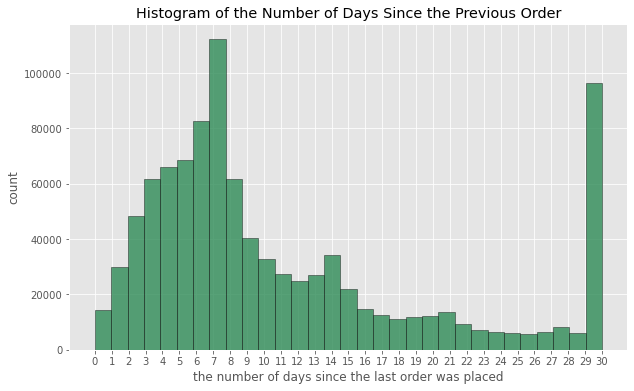

In [44]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(order_times_df['days_since_prior_order'], bins=31, color='seagreen', edgecolor='k', alpha=0.8)
plt.xticks(ticks=np.arange(0,31,1))
ax.set_title('Histogram of the Number of Days Since the Previous Order')
ax.set_xlabel('the number of days since the last order was placed')
plt.savefig('Histogram of the Number of Days Since the Previous Order.png')
ax.set_ylabel('count');

Most customers order once a week with many ordering even more often. Maybe this reflects a population in a dense urban area where people tend to shop more often for fewer items as opposed to one larger trip a week. There are peaks every seven days for those shopping every two, three, or four weeks. 

Finally, it's likely that '30' also represents '30 or more' days; there may be a lot of customers who mostly shop on their own and only use Instacart occasionally.

Let's see whether these time/frequency aspects relate to departments and aisles:

In [45]:
#Reapplying the missing department & aisle records from before:
order_times_df.loc[order_times_df['product_name'] == 'Organic Riced Cauliflower', 'dept_name'] = 'produce'
order_times_df.loc[order_times_df['product_name'] == 'Organic Riced Cauliflower', 'aisle_name'] = 'fresh vegetables'

order_times_df.loc[order_times_df['product_name'] == 'Organic Mango Yogurt', 'dept_name'] = 'dairy eggs'
order_times_df.loc[order_times_df['product_name'] == 'Organic Mango Yogurt', 'aisle_name'] = 'yogurt'

order_times_df.loc[order_times_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'dept_name'] = 'frozen'
order_times_df.loc[order_times_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'aisle_name'] = 'ice cream ice'

order_times_df.loc[order_times_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'
order_times_df.loc[order_times_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'

order_times_df.loc[order_times_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'dept_name'] = 'dairy eggs'
order_times_df.loc[order_times_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'aisle_name'] = 'yogurt'
#The dropping the remaining missing departments:
order_times_df = order_times_df[order_times_df['dept_name'] != 'missing']

In [46]:
#order_times_by_dept = order_times_df.groupby('dept_name')['days_since_prior_order'].mean()
#No interesting patters there, how about order times by aisles?
order_times_by_aisle = order_times_df.groupby('aisle_name')['order_hour_of_day'].mean().sort_values(ascending=False)
order_times_by_aisle 

aisle_name
red wines                  14.009786
ice cream ice              13.990020
fresh pasta                13.831431
shave needs                13.830409
frozen vegan vegetarian    13.829991
                             ...    
cold flu allergy           12.980392
cleaning products          12.948982
tea                        12.939361
trail mix snack mix        12.805695
mint gum                   12.712912
Name: order_hour_of_day, Length: 134, dtype: float64

In [47]:
round(order_times_by_aisle.min(), 1), round(order_times_by_aisle.max(),1)
#Not a ton of difference here, but I suppose that goes back to how many more orders are placed
# between 10am-3pm as well as the fact that these aisles are just a part of a larger order.

(12.7, 14.0)

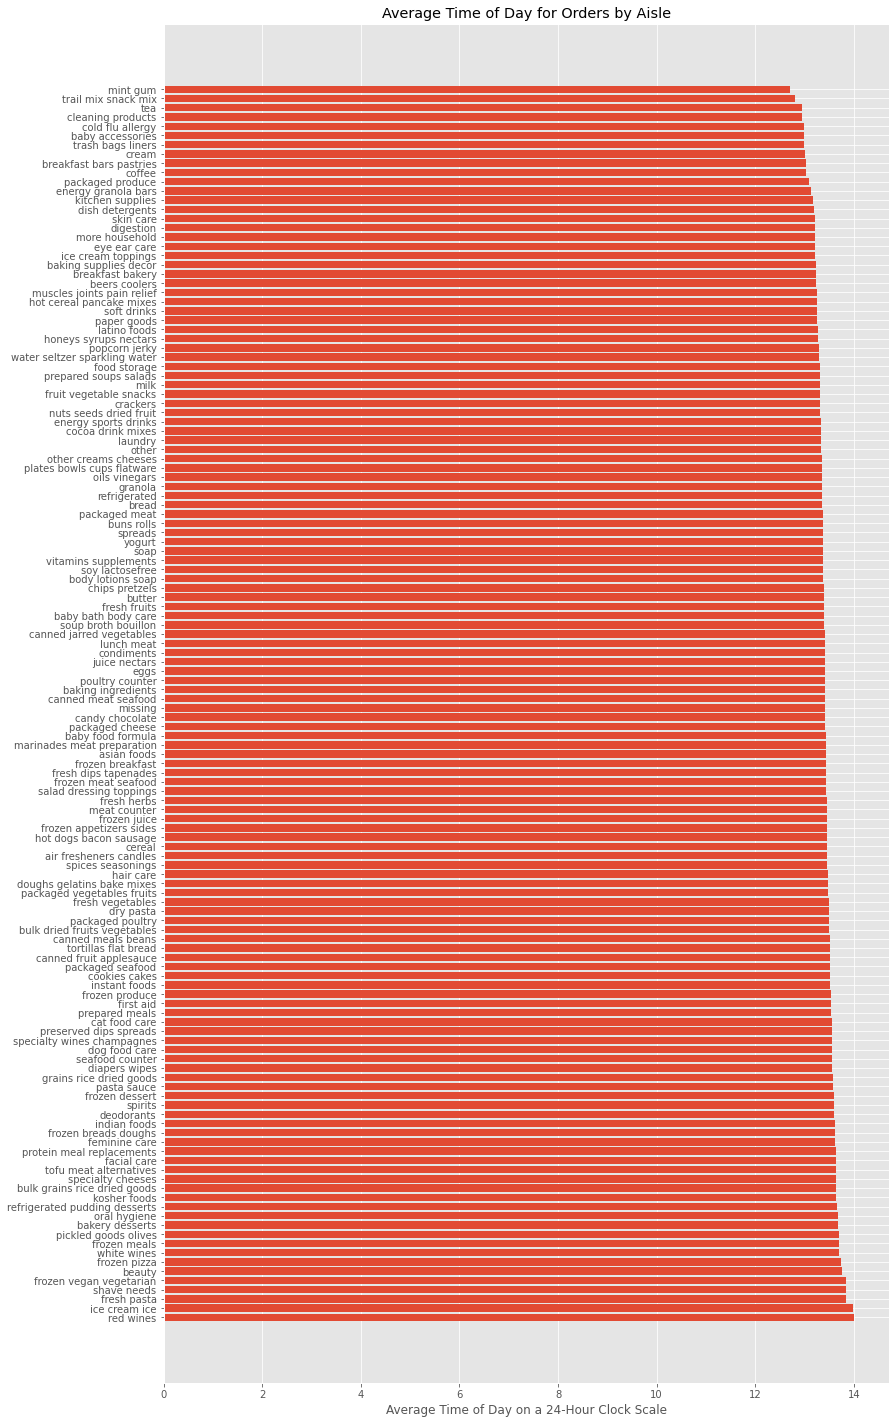

In [48]:
#Let's visualize these aisles to see the scale of difference:
fig, ax = plt.subplots(figsize=(13,25))
ax.barh(order_times_by_aisle.index, order_times_by_aisle.values)
ax.set_title('Average Time of Day for Orders by Aisle')
ax.set_xlabel('Average Time of Day on a 24-Hour Clock Scale');

Even though there doesn't seem to be a large *overall* difference among aisles and the time of day, it *is* interesting to see how the aisles with the earliest-ordered products include household cleaning items, breakfast products, medicine, and "baby accessories." Meanwhile, the latest-ordered aisles involve more in the way of desserts, alcohol, frozen goods, and carbohydrates along with the somewhat puzzling inclusion of beauty products and "shave needs".

I wonder how these look when plotted together:

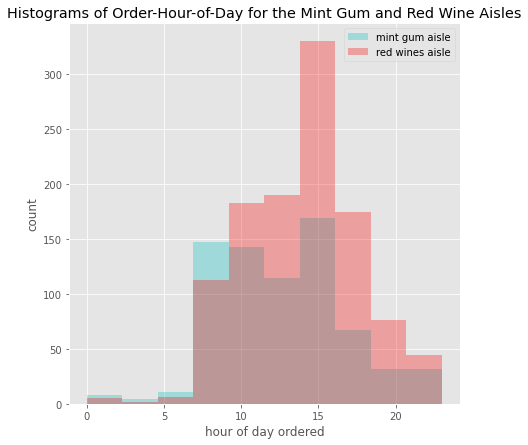

In [49]:
mint_gum_aisle = order_times_df[order_times_df['aisle_name'] == 'mint gum']
mint_gum_aisle_ohod = mint_gum_aisle['order_hour_of_day']
red_wines_aisle = order_times_df[order_times_df['aisle_name'] == 'red wines']
red_wines_aisle_ohod = red_wines_aisle['order_hour_of_day']

fig, ax = plt.subplots(figsize=(7,7))
ax.hist(mint_gum_aisle_ohod, color='c', alpha=0.3, label='mint gum aisle')
ax.hist(red_wines_aisle_ohod, color='r', alpha=0.3, label='red wines aisle')
ax.set_title('Histograms of Order-Hour-of-Day for the Mint Gum and Red Wine Aisles')
ax.set_xlabel('hour of day ordered')
ax.set_ylabel('count')
plt.legend();

These two aisles differ by volume and also seem to have a different distribution of order-hour-of-day, so they don't make the best comparison. In any case, the time of day may make a slight difference in what Instacart can expect to see ordered, but it doesn't appear to be an especially compelling factor. 

What about aisles and days since prior order?

In [50]:
dspo_by_aisle = order_times_df.groupby('aisle_name')['days_since_prior_order'].mean().sort_values(ascending=False)
dspo_by_aisle 

aisle_name
facial care                     14.519444
shave needs                     13.977636
eye ear care                    13.563636
first aid                       13.296029
body lotions soap               12.759056
                                  ...    
spirits                         10.048285
bulk dried fruits vegetables     9.955017
baby food formula                9.935853
specialty wines champagnes       9.718563
vitamins supplements             9.462244
Name: days_since_prior_order, Length: 134, dtype: float64

In [51]:
#Let's examine the minimum and maximum values for an overall look at the spread:
round(dspo_by_aisle.min(),1), round(dspo_by_aisle.max(),1)
#Bigger difference among aisles here, from 9.5 days since the order minimum average
# for vitamins/supplements and 14.5 days maximum average for facial care.

(9.5, 14.5)

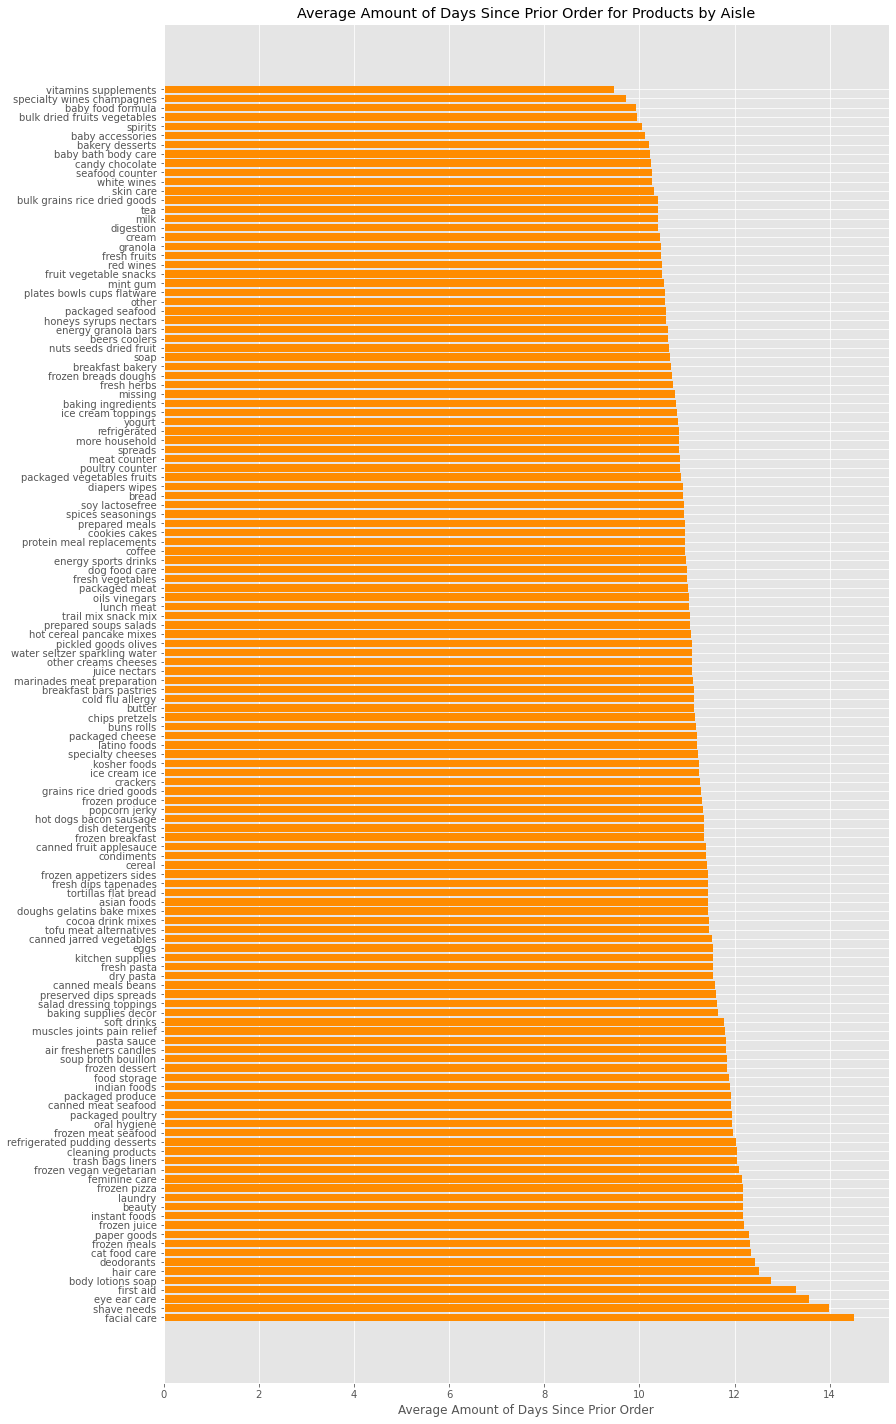

In [52]:
#Graphing the data for a more detailed look at how it varies:
fig, ax = plt.subplots(figsize=(13,25))
ax.barh(dspo_by_aisle.index, dspo_by_aisle.values, color='darkorange')
ax.set_title('Average Amount of Days Since Prior Order for Products by Aisle')
ax.set_xlabel('Average Amount of Days Since Prior Order');

A wider variety emerges here with days_since_prior_order among aisles. Vitamins, alcohol, baby products, candy, and seafood make for quite the interesting group of most-frequently ordered aisles. On the other end of the spectrum, it looks like beauty products come together to be ordered least frequently. These may be things that last longer or are used more gradually.

## Specifying business recommendations with linear regression analysis


A more general approach to this data through EDA has helped highlight a few interesting relationships among the data, but linear regression analysis may help narrow down some specifics. Applying a regression model to this dataset with the goal of predicting *which products users will order next* makes it difficult to select a *single* target variable. 

In its place, we can substitute an aggregated target column: the percentage of a products total orders that are reorders, which speaks to the likelihood of a product being reordered. With this target in mind, regression analysis will hopefully help determine which factors influence product (re)selection the most. 

### Recapping our EDA findings and formulating a baseline regression model:

So far, it seems like the following relationships seem to correlate strongly (or at least they made for some interesting insights):

- add-to-cart orders versus their percentage-likelihood-to-be-a-reorder was a big one
- the enormous nature of the produce & 'dairy egg' departments probably shouldn't be ignored
- the weekend's order density seems noteworthy alongside the frequency of people ordering once-a-week

Of course, we can also put together a larger DataFrame and run a correlation heatmap to see what else we see. First, let's bring together a broader DataFrame that includes products, reordering percentages, and time-related aspects all in one place:

In [53]:
broader_product_df = pd.read_sql(
                """SELECT
                    opp.product_id,
                    p.product_name,
                    p.department_id,
                    d.department AS dept_name,
                    p.aisle_id,
                    a.aisle AS aisle_name,
                    AVG(o.order_dow) AS avg_order_day_of_week,
                    AVG(o.order_hour_of_day) AS avg_order_hour_of_day,
                    AVG(o.days_since_prior_order) AS avg_days_since_prior_order,
                    AVG(opp.add_to_cart_order) AS avg_added_to_cart_order,
                    COUNT(product_id) AS times_ordered,                    
                    SUM(opp.reordered) AS times_reordered                    
                FROM orders AS o
                JOIN order_products__prior AS opp
                    USING(order_id)
                JOIN products AS p
                    USING(product_id)
                JOIN aisles AS a
                    USING(aisle_id)
                JOIN departments AS d
                    USING(department_id)
                GROUP BY product_id
                ORDER BY product_id;
                """, conn)
broader_product_df.head()

,product_id,product_name,department_id,dept_name,aisle_id,aisle_name,avg_order_day_of_week,avg_order_hour_of_day,avg_days_since_prior_order,avg_added_to_cart_order,times_ordered,times_reordered
0,1,Chocolate Sandwich Cookies,19,snacks,61,cookies cakes,2.573770,13.786885,12.627119,5.786885,61,42
1,2,All-Seasons Salt,13,pantry,104,spices seasonings,1.333333,13.000000,14.666667,12.000000,3,0
2,3,Robust Golden Unsweetened Oolong Tea,7,beverages,94,tea,3.000000,12.666667,20.666667,3.000000,3,2
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,1,frozen,38,frozen meals,3.500000,14.300000,12.500000,9.000000,10,3
4,8,Cut Russet Potatoes Steam N' Mash,1,frozen,116,frozen produce,0.500000,13.500000,4.000000,9.500000,2,0


Now we need to re-add the reorder_percentage column and re-run the missing department & aisle fix for popular products:

In [54]:
#Percentage_as_reorder_column:
broader_product_df['percentage_as_a_reorder'] = broader_product_df['times_reordered'] / broader_product_df['times_ordered']
#Re-running the missing department & aisle fix for the popular products:
broader_product_df.loc[broader_product_df['product_name'] == 'Organic Riced Cauliflower', 'dept_name'] = 'produce'
broader_product_df.loc[broader_product_df['product_name'] == 'Organic Riced Cauliflower', 'aisle_name'] = 'fresh vegetables'

broader_product_df.loc[broader_product_df['product_name'] == 'Organic Mango Yogurt', 'dept_name'] = 'dairy eggs'
broader_product_df.loc[broader_product_df['product_name'] == 'Organic Mango Yogurt', 'aisle_name'] = 'yogurt'

broader_product_df.loc[broader_product_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'dept_name'] = 'frozen'
broader_product_df.loc[broader_product_df['product_name'] == 'Peanut Butter Ice Cream Cup', 'aisle_name'] = 'ice cream ice'

broader_product_df.loc[broader_product_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'
broader_product_df.loc[broader_product_df['product_name'] == 'Organic Celery Bunch', 'dept_name'] = 'produce'

broader_product_df.loc[broader_product_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'dept_name'] = 'dairy eggs'
broader_product_df.loc[broader_product_df['product_name'] == 'Organic Whole Milk Washington Black Cherry Yogurt', 'aisle_name'] = 'yogurt'

broader_product_df.head()

,product_id,product_name,department_id,dept_name,aisle_id,aisle_name,avg_order_day_of_week,avg_order_hour_of_day,avg_days_since_prior_order,avg_added_to_cart_order,times_ordered,times_reordered,percentage_as_a_reorder
0,1,Chocolate Sandwich Cookies,19,snacks,61,cookies cakes,2.573770,13.786885,12.627119,5.786885,61,42,0.688525
1,2,All-Seasons Salt,13,pantry,104,spices seasonings,1.333333,13.000000,14.666667,12.000000,3,0,0.000000
2,3,Robust Golden Unsweetened Oolong Tea,7,beverages,94,tea,3.000000,12.666667,20.666667,3.000000,3,2,0.666667
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,1,frozen,38,frozen meals,3.500000,14.300000,12.500000,9.000000,10,3,0.300000
4,8,Cut Russet Potatoes Steam N' Mash,1,frozen,116,frozen produce,0.500000,13.500000,4.000000,9.500000,2,0,0.000000


Next, we can construct a correlation heatmap using Seaborn to see which features correlate the most. 

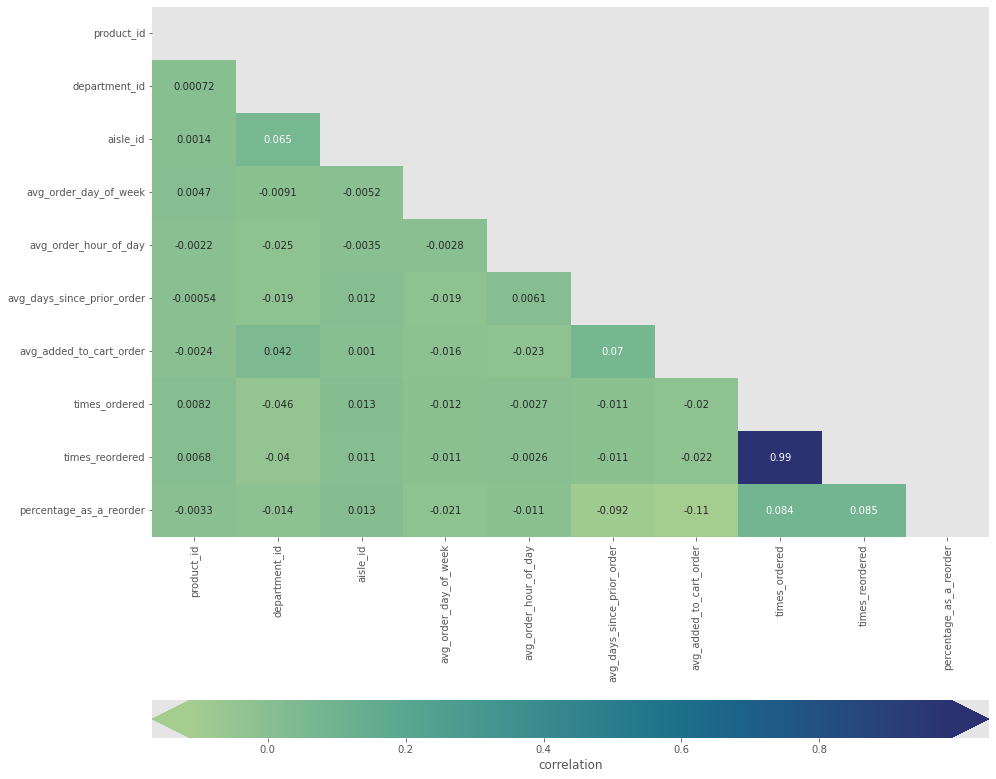

In [55]:
import seaborn as sns
heatmap_data = broader_product_df
corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=corr, mask=np.triu(corr), ax=ax, annot=True, cmap="crest",
            cbar_kws={'label':'correlation', 'orientation':'horizontal', 'pad':.2, 'extend':'both'});

Besides the obvious and redundant correlation between times_ordered & times_reordered, there aren't too many compelling correlations here. However, there are a few that are stronger than others and may merit further investigation. 

The next two strongest correlations appear in the percentage_as_a_reorder column:
- with avg_added_to_cart_order at -0.11 
- with avg_days_since_prior_order at -0.092

Perhaps I can run a linear regression model with percentage_as_a_reorder as the target. Not only does it involve some stronger correlations, but it translates well to our business inquiry. The next two strongest correlations also involve percentage_as_a_reorder, but they're redundant because they're what constitutes this column in the first place (the two correlations to times_ordered and times_reordered). 

Two other correlations that may be worth looking into pertain to avg_added_to_cart_order: 
- avg_added_to_cart_order and avg_days_since_prior_order (0.07)
- avg_added_to_cart_order and department_id (0.042)

Looking back to my biggest impressions from the EDA, it does seem like the biggest correlation we'll find here is between avg_added_to_cart_order and percentage_as_a_reorder. In other words, people tend to add their reorders to the cart early on in the ordering process.

### Overall regression analysis process:

Below, I start with a baseline model that involves a target variable (percentage_as_a_reorder) and the single strongest feature (avg_added_to_cart_order). Next, I will iteratively improve on that baseline by (1) including and refining further features as well as (2) reconsidering which products make the most sense for predicting reorders. By the end, a stronger model emerges that helps shed light on which factors to consider when predicting reorders.

Here are the overall process steps to make a long story short:

1. baseline model with all 35,449 products from our existing broader_products_df (dismal R-squared of 0.013)
2. a quick realization that rarely-ordered products are keeping the model from making meaningful predictions
3. dropping all products from our data that were ordered fewer than 100 times
4. constructing a "new" baseline with this more useable data (R-squared 0.32)
5. considering, adding, and refining additional features for our final model (R-squared 0.434)

In [56]:
#Importing and constructing the baseline model with the StatsModels library:
import statsmodels.api as sm
from statsmodels.formula.api import ols
#Suppressing future warnings that will occur during multiple regression models: 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#Constructing the baseline model:
formula = 'percentage_as_a_reorder ~ avg_added_to_cart_order'
model = ols(formula=formula, data=broader_product_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.013
Model:                                 OLS   Adj. R-squared:                  0.013
Method:                      Least Squares   F-statistic:                     452.1
Date:                     Sun, 08 Oct 2023   Prob (F-statistic):           1.06e-99
Time:                             17:04:52   Log-Likelihood:                -10489.
No. Observations:                    35449   AIC:                         2.098e+04
Df Residuals:                        35447   BIC:                         2.100e+04
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.4854      0.004    137.240      0.000       0.478       0.492
avg_added_to_cart_order    -0.0073      0.000    -21.263      0.000      -0.008      -0.007
==============================================================================
Omnibus:                     6135.661   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1452.562
Skew:                           0.156   Prob(JB):                         0.00
Kurtosis:                       2.059   Cond. No.                         21.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Interpreting and refining the baseline model

That's a rough R-squared score. In other words, the order in which customers add items to their cart is not able to explain much about which products are most likely to be reordered. 

However, it's still better than zero, so let's at least see what we can learn from this model by visualizing the correlation:

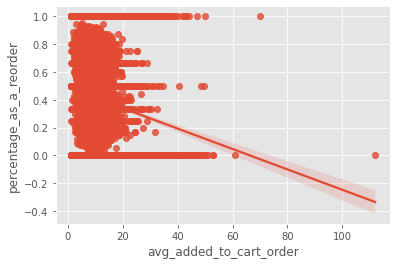

In [57]:
sns.regplot(x='avg_added_to_cart_order', y='percentage_as_a_reorder', data=broader_product_df);

This brings us back to the EDA portion that saw a similar mess. Why are there so many percentages clustering together?

In [58]:
broader_product_df['percentage_as_a_reorder'].value_counts()

0.000000    9438
1.000000    3924
0.500000    3347
0.333333    1698
0.666667    1392
            ... 
0.590062       1
0.616495       1
0.629808       1
0.602914       1
0.642276       1
Name: percentage_as_a_reorder, Length: 2512, dtype: int64

What a mess. We have too many single-ordered products at 0%; we can probably just get rid of them because they are obscure products that don't really inform reordering. However, they do constitute 26% of our broader_product_df. Well, I suppose if the end-goal is to better predict future orders, then these unpopular 0% reorder products probably don't really matter, so we'll drop them.

In [59]:
broader_product_df = broader_product_df[broader_product_df['percentage_as_a_reorder'] != 0]
broader_product_df['percentage_as_a_reorder'].value_counts()

1.000000    3924
0.500000    3347
0.333333    1698
0.666667    1392
0.250000     829
            ... 
0.590062       1
0.616495       1
0.629808       1
0.602914       1
0.642276       1
Name: percentage_as_a_reorder, Length: 2511, dtype: int64

We also have a ton of 100%-reordered products, which seems odd and warrants further investigation. 

In [60]:
broader_product_df[broader_product_df['percentage_as_a_reorder'] == 1]

,product_id,product_name,department_id,dept_name,aisle_id,aisle_name,avg_order_day_of_week,avg_order_hour_of_day,avg_days_since_prior_order,avg_added_to_cart_order,times_ordered,times_reordered,percentage_as_a_reorder
9,15,Overnight Diapers Size 6,18,babies,56,diapers wipes,2.000000,7.000000,4.000000,1.000000,1,1,1.0
20,33,Organic Spaghetti Style Pasta,9,dry goods pasta,131,dry pasta,3.000000,10.666667,10.666667,14.666667,3,3,1.0
27,41,Organic Sourdough Einkorn Crackers Rosemary,19,snacks,78,crackers,2.500000,17.500000,29.500000,9.500000,2,2,1.0
45,60,Cheesy Creations Roasted Garlic Parmesan Sauce,9,dry goods pasta,9,pasta sauce,5.000000,16.000000,30.000000,17.000000,1,1,1.0
52,68,"Pancake Mix, Buttermilk",14,breakfast,130,hot cereal pancake mixes,2.333333,17.000000,3.666667,1.666667,3,3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35423,49648,Squid Ink Fettuccini,9,dry goods pasta,131,dry pasta,1.000000,9.000000,21.000000,8.000000,1,1,1.0
35424,49649,Refreshing Remover Cleansing Towelettes,11,personal care,73,facial care,6.000000,12.000000,15.000000,2.000000,1,1,1.0
35437,49674,Frozen Greek Yogurt Bars Chocolate Chip,1,frozen,37,ice cream ice,4.000000,22.000000,1.000000,2.000000,1,1,1.0
35439,49676,Ultra Red Energy Drink,7,beverages,64,energy sports drinks,1.000000,13.000000,12.000000,9.000000,1,1,1.0


Ah, this is due to products that have only been ordered once or just a few times and each time it was a reorder. This points to the fact that items appearing on here once are influencing the regression analysis *just as much* as bananas are with over 150,000 orders. This goes back to the fact that I'm grouping by products in this df, which I did because the goal is to predict *products*.

Let's consider what makes an item obscure enough to throw off our ability to predict reordering. What if we were to, say, define "obscure" as ordered fewer than five times:

In [61]:
no_of_obscure_orders = len(broader_product_df[broader_product_df['times_ordered'] < 5])

print("Length of broader_product_df:", len(broader_product_df))
print("Number of obscure product records:", no_of_obscure_orders)
print("Percentage that these obscure orders take up:", round(no_of_obscure_orders/len(broader_product_df),3))

Length of broader_product_df: 26011
Number of obscure product records: 9130
Percentage that these obscure orders take up: 0.351


Hmm, that's a lot of our data. I wonder if there's a way for me to weigh these or perhaps I could standardize them with a logarithmic transformation. Let's look at the distribution: 

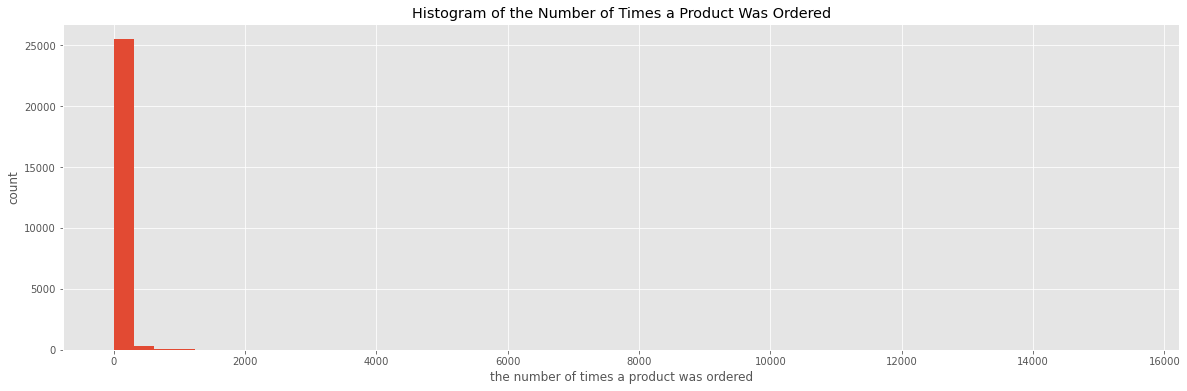

In [62]:
fig, ax = plt.subplots(figsize=(20,6))
ax.hist(broader_product_df['times_ordered'], bins=50)
#plt.xticks(ticks=np.arange(0,31,1))
ax.set_title('Histogram of the Number of Times a Product Was Ordered')
ax.set_xlabel('the number of times a product was ordered')
ax.set_ylabel('count');

In [63]:
broader_product_df['times_ordered'].value_counts()

2       2624
1       2592
3       2193
4       1721
5       1425
        ... 
776        1
1336       1
438        1
415        1
3111       1
Name: times_ordered, Length: 689, dtype: int64

This distribution is so far from normal that logarithmic transformation won't help; we need to reconsider the distribution altogether. 

## Reconstructing the baseline model

**Only frequently-ordered products are going to help predict what's going to be reordered. Even if we lose a lot of product records in the broader_product_df by only focusing on more frequently ordered products, that's fine because the remaining products are the ones that are meaningfully reordered in the first place. Products that are barely ordered aren't going to be useful for predicting purposes.** 

Dropping products ordered fewer than 100 times seems reasonable and still leaves 1,856 products in the mix, so let's start there.

In [64]:
products_worth_considering = broader_product_df[broader_product_df['times_ordered'] > 100]
products_worth_considering.shape

(1856, 13)

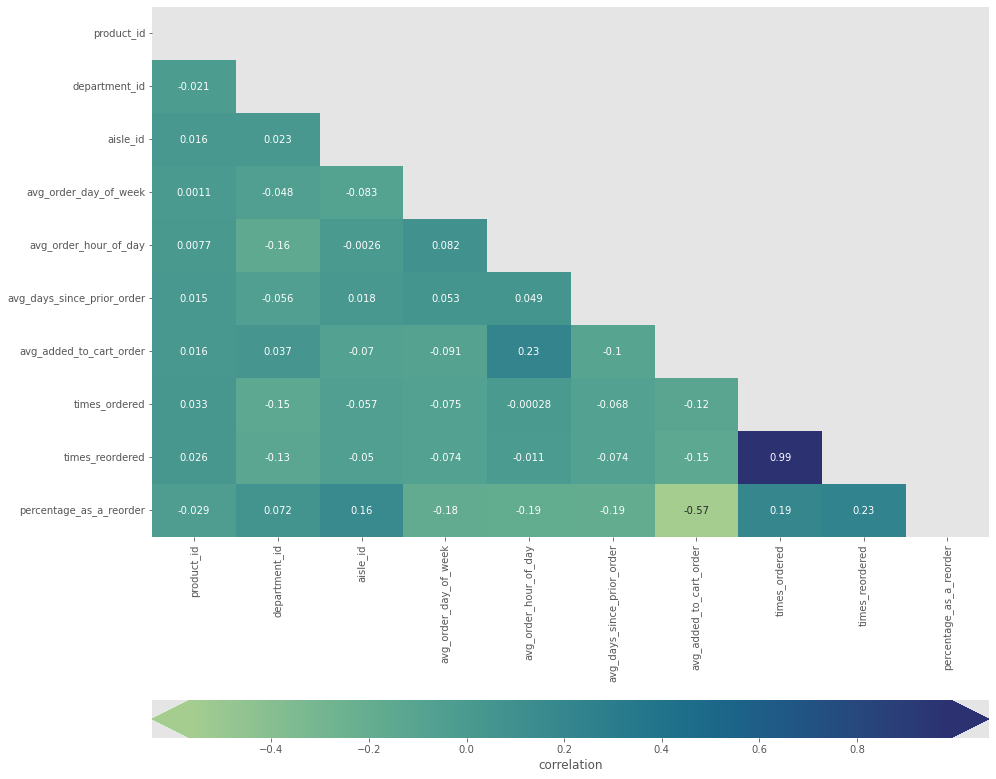

In [65]:
#Heatmap those correlations
heatmap_data = products_worth_considering
corr = heatmap_data.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(data=corr, mask=np.triu(corr), ax=ax, annot=True, cmap="crest",
            cbar_kws={'label':'correlation', 'orientation':'horizontal', 'pad':.2, 'extend':'both'});

We find a lot more in the way of compelling correlations here. 

### Initializing the "new" baseline model with refined data

Avg_added_to_cart_order is still our strongest meaningful correlation, so let's remake our baseline model with it: 

In [66]:
#Refined df baseline:
formula = 'percentage_as_a_reorder ~ avg_added_to_cart_order'
model = ols(formula=formula, data=products_worth_considering).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.320
Model:                                 OLS   Adj. R-squared:                  0.320
Method:                      Least Squares   F-statistic:                     873.9
Date:                     Sun, 08 Oct 2023   Prob (F-statistic):          1.09e-157
Time:                             17:04:57   Log-Likelihood:                 1549.7
No. Observations:                     1856   AIC:                            -3095.
Df Residuals:                         1854   BIC:                            -3084.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.9592      0.013     76.203      0.000       0.935       0.984
avg_added_to_cart_order    -0.0434      0.001    -29.562      0.000      -0.046      -0.040
==============================================================================
Omnibus:                      291.263   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              520.425
Skew:                          -0.989   Prob(JB):                    9.80e-114
Kurtosis:                       4.678   Cond. No.                         44.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is a massive improvement over our previous baseline with all 35,449 products included. The first issue in improving it further is to investigate the times_ordered distribution with just these more popular products.

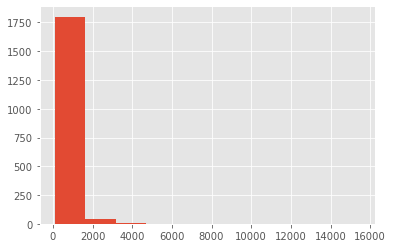

In [67]:
products_worth_considering['times_ordered'].hist();

This is still pretty far from a normal distribution. Let's perform a logarithmic transformation to reorganize this distribution in terms of percentages and see if we can find a viable distribution to use:

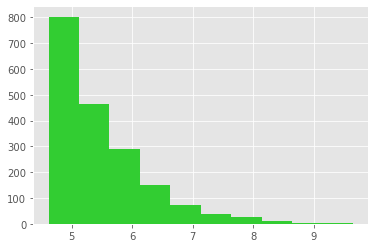

In [68]:
products_worth_considering['times_ordered_log'] = np.log(products_worth_considering['times_ordered'])
plt.hist(products_worth_considering['times_ordered_log'], color='limegreen');

Even the times_ordered_log column is too really skewed, so we can't include it here. Moving on, our previous EDA and our correlation heatmap found that the 'avg_days_since_prior_order' shows a small correlation with reordering. Maybe adding it here will help improve our model:

In [69]:
#Model with top features of products_worth_considering that still make sense together:
target = products_worth_considering['percentage_as_a_reorder']
predictors = products_worth_considering[['avg_added_to_cart_order', 'avg_days_since_prior_order']]
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.383
Model:                                 OLS   Adj. R-squared:                  0.383
Method:                      Least Squares   F-statistic:                     576.2
Date:                     Sun, 08 Oct 2023   Prob (F-statistic):          2.62e-195
Time:                             17:04:58   Log-Likelihood:                 1640.1
No. Observations:                     1856   AIC:                            -3274.
Df Residuals:                         1853   BIC:                            -3258.
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.2869      0.027     48.289      0.000       1.235       1.339
avg_added_to_cart_order       -0.0453      0.001    -32.263      0.000      -0.048      -0.043
avg_days_since_prior_order    -0.0282      0.002    -13.768      0.000      -0.032      -0.024
==============================================================================
Omnibus:                      416.326   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              997.212
Skew:                          -1.222   Prob(JB):                    2.87e-217
Kurtosis:                       5.631   Cond. No.                         161.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is definitely an improvement. We have a viable model with a low Prob (F-statistic) and coefficients with low p-values. The condition number isn't too high, either. However, I think we can do better if we also consider a few additional order-frequency features: day-of-the-week and time-of-day. 

In [70]:
predictors = products_worth_considering[['avg_added_to_cart_order', 'avg_days_since_prior_order', \
                                         'avg_order_day_of_week', 'avg_order_hour_of_day']]
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.434
Model:                                 OLS   Adj. R-squared:                  0.433
Method:                      Least Squares   F-statistic:                     354.6
Date:                     Sun, 08 Oct 2023   Prob (F-statistic):          8.68e-227
Time:                             17:04:58   Log-Likelihood:                 1719.3
No. Observations:                     1856   AIC:                            -3429.
Df Residuals:                         1851   BIC:                            -3401.
Df Model:                                4                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.7778      0.082     21.613      0.000       1.616       1.939
avg_added_to_cart_order       -0.0464      0.001    -33.362      0.000      -0.049      -0.044
avg_days_since_prior_order    -0.0269      0.002    -13.674      0.000      -0.031      -0.023
avg_order_day_of_week         -0.1503      0.012    -12.620      0.000      -0.174      -0.127
avg_order_hour_of_day         -0.0062      0.006     -1.062      0.289      -0.018       0.005
==============================================================================
Omnibus:                      415.316   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1022.966
Skew:                          -1.207   Prob(JB):                    7.34e-223
Kurtosis:                       5.720   Cond. No.                         724.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

An improved R-sqaured score shows our new model can explain more of our data, but the condition number has substantially increased. This means we have some features that relate to each other too much. This probably relates to day-of-the-week and hour_of_day interacting. We should remove hour_of_day because its p-value is problematic and see if our model improves. 

In [71]:
predictors = products_worth_considering[['avg_added_to_cart_order', 'avg_days_since_prior_order', \
                                         'avg_order_day_of_week']]
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.434
Model:                                 OLS   Adj. R-squared:                  0.433
Method:                      Least Squares   F-statistic:                     472.4
Date:                     Sun, 08 Oct 2023   Prob (F-statistic):          6.46e-228
Time:                             17:04:58   Log-Likelihood:                 1718.7
No. Observations:                     1856   AIC:                            -3429.
Df Residuals:                         1852   BIC:                            -3407.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.7022      0.041     41.206      0.000       1.621       1.783
avg_added_to_cart_order       -0.0468      0.001    -34.627      0.000      -0.049      -0.044
avg_days_since_prior_order    -0.0270      0.002    -13.780      0.000      -0.031      -0.023
avg_order_day_of_week         -0.1516      0.012    -12.795      0.000      -0.175      -0.128
==============================================================================
Omnibus:                      413.317   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1019.437
Skew:                          -1.201   Prob(JB):                    4.29e-222
Kurtosis:                       5.723   Cond. No.                         271.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Refining our improved model

The model above is a big improvement even over our "revised baseline" with more popular products. It also seems like issues of multicollinearity may be improved, but the condition number is less than ideal at 271. Let's look into the distribution of our features to see whether we have any problems there:

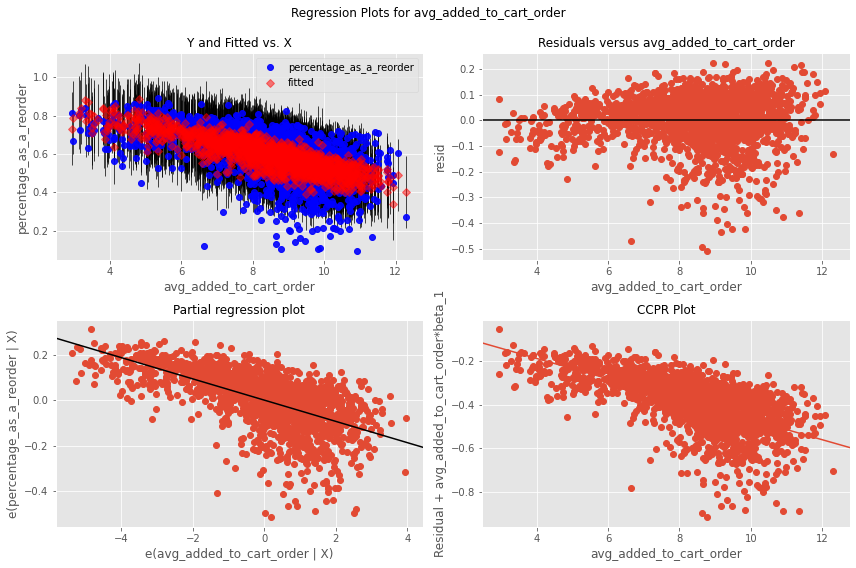

In [72]:
#Regression residuals plot for the 'avg_added_to_cart_order' feature
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'avg_added_to_cart_order', fig=fig)
#Not ideal, but not too problematic

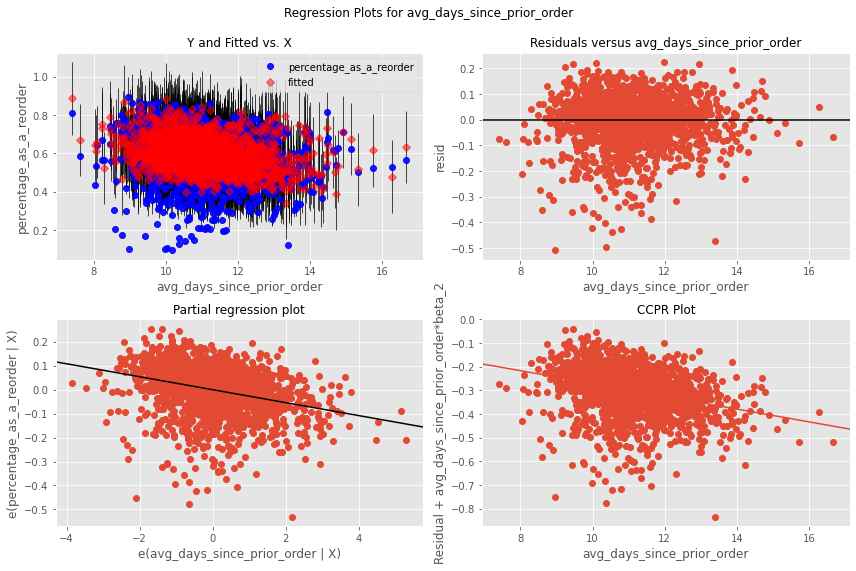

In [73]:
#Residuals for the 'avg_days_since_prior_order' feature
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'avg_days_since_prior_order', fig=fig)
#Again, not entirely normal, but not too worrisome given the variability in this data

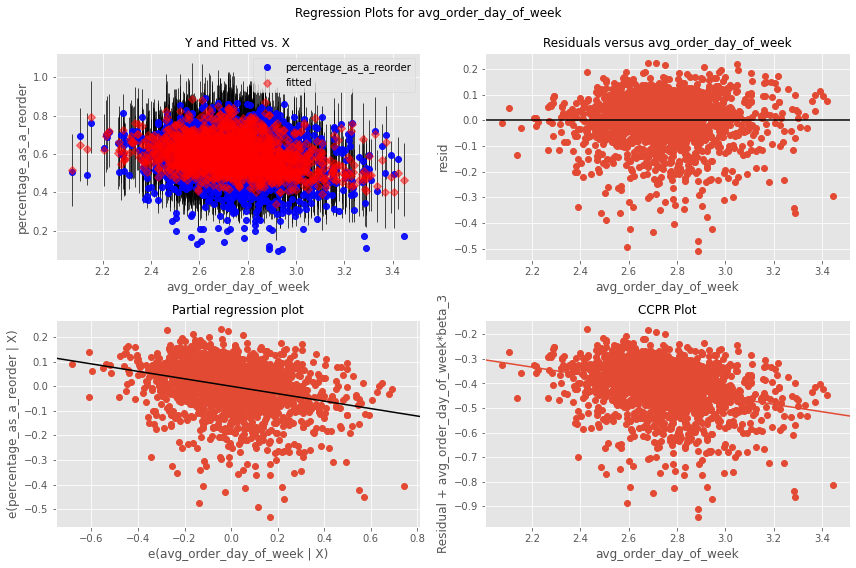

In [74]:
#Residuals for the 'avg_order_day_of_week' feature
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'avg_order_day_of_week', fig=fig)

These residuals are not ideally normal, but they're not unreasonable given the variation in even this more selective product data.

While 0.434 may not be a highly compelling R-squared score, it is likely the best we can achieve with thoughtful, meaningful features. Considering the large variability in this dataset - even when excluding products sold fewer than 100 times - [a relatively lower R-squared score may be expected and all we can ask for](https://www.statology.org/good-r-squared-value/#:~:text=How%20high%20an%20R%2Dsquared,extreme%20variability%20in%20the%20dataset.), but our model can still tell us something about costumer habits. 

Before deciding on this model, let's also check for normal distributions among our remaining features:

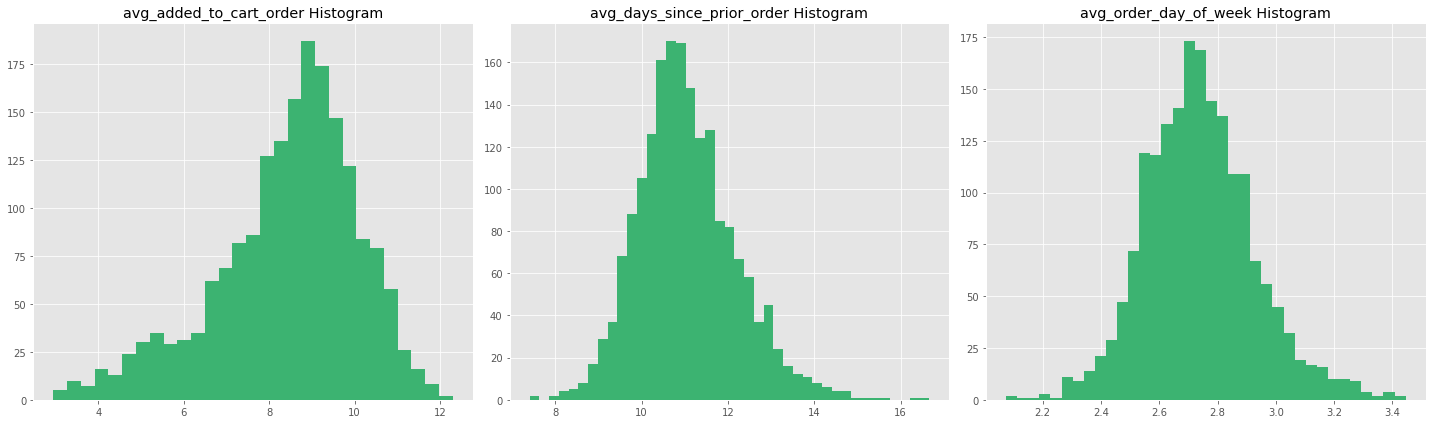

In [75]:
#Set up figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))
#Plot histograms
ax1.hist(products_worth_considering['avg_added_to_cart_order'], color='mediumseagreen', bins='auto')
ax2.hist(products_worth_considering['avg_days_since_prior_order'], color='mediumseagreen', bins='auto')
ax3.hist(products_worth_considering['avg_order_day_of_week'], color='mediumseagreen', bins='auto')
#Title histograms
ax1.set_title('avg_added_to_cart_order Histogram')
ax2.set_title('avg_days_since_prior_order Histogram')
ax3.set_title('avg_order_day_of_week Histogram')
#Polish figure
plt.tight_layout();

That 'avg_added_to_cart_order' seems a bit off. Let's investigate that a little further:

In [76]:
from scipy.stats import kurtosis, skew
print("skewness of avg_added_to_cart_order:", skew(products_worth_considering['avg_added_to_cart_order']))
print("kurtosis of avg_added_to_cart_order:", kurtosis(products_worth_considering['avg_added_to_cart_order']))
print("-------------------------------------------------")
print("skewness of avg_days_since_prior_order:", skew(products_worth_considering['avg_days_since_prior_order']))
print("kurtosis of avg_days_since_prior_order:", kurtosis(products_worth_considering['avg_days_since_prior_order']))
print("-------------------------------------------------")
print("skewness of avg_order_day_of_week:", skew(products_worth_considering['avg_order_day_of_week']))
print("kurtosis of avg_order_day_of_week:", kurtosis(products_worth_considering['avg_order_day_of_week']))

skewness of avg_added_to_cart_order: -0.721710270799695
kurtosis of avg_added_to_cart_order: 0.36326791082728693
-------------------------------------------------
skewness of avg_days_since_prior_order: 0.5489205808396845
kurtosis of avg_days_since_prior_order: 0.8904644995523952
-------------------------------------------------
skewness of avg_order_day_of_week: 0.33248295525049604
kurtosis of avg_order_day_of_week: 0.7057079390413143


The skewneess of 'avg_days_since_prior_order' *technically* veers into the realm of "slightly skewed" at 0.55, but even then, I'd rather not logarithmically transform it since it can make the coefficients of the model more difficult to interpret. If that's okay, then it looks like the only problematic score here is the skewness of 'avg_added_to_cart_order' at -0.72. That probably merits a logarithmic transformation:

skewness of avg_added_to_cart_order_log: -1.431287541104821
kurtosis of avg_added_to_cart_order_log: 2.432126291748956


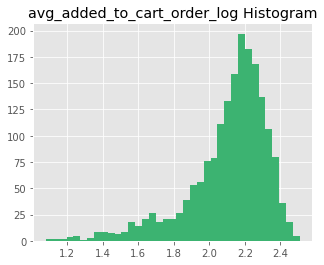

In [77]:
#Performing the logarithmic transformation
products_worth_considering['avg_added_to_cart_order_log'] = np.log(products_worth_considering['avg_added_to_cart_order'])
#Plotting it on the same scale we saw above when we plotted all the distributions' histograms
fig, ax = plt.subplots(figsize=(5,4))
ax.hist(products_worth_considering['avg_added_to_cart_order_log'], color='mediumseagreen', bins='auto')
ax.set_title('avg_added_to_cart_order_log Histogram')
#Printing the skew & kurtosis scores
print("skewness of avg_added_to_cart_order_log:", skew(products_worth_considering['avg_added_to_cart_order_log']))
print("kurtosis of avg_added_to_cart_order_log:", kurtosis(products_worth_considering['avg_added_to_cart_order_log']))

Ha! That made it worse. Perhaps there weren't enough higher values to help balance out the lower ones. In any case, I think our current last model is as good as it gets. Here it is again as the final results are summarized:

In [78]:
predictors = products_worth_considering[['avg_added_to_cart_order', 'avg_days_since_prior_order', \
                                         'avg_order_day_of_week']]
predictors = sm.add_constant(predictors)
model = sm.OLS(target, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     percentage_as_a_reorder   R-squared:                       0.434
Model:                                 OLS   Adj. R-squared:                  0.433
Method:                      Least Squares   F-statistic:                     472.4
Date:                     Sun, 08 Oct 2023   Prob (F-statistic):          6.46e-228
Time:                             17:05:01   Log-Likelihood:                 1718.7
No. Observations:                     1856   AIC:                            -3429.
Df Residuals:                         1852   BIC:                            -3407.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          1.7022      0.041     41.206      0.000       1.621       1.783
avg_added_to_cart_order       -0.0468      0.001    -34.627      0.000      -0.049      -0.044
avg_days_since_prior_order    -0.0270      0.002    -13.780      0.000      -0.031      -0.023
avg_order_day_of_week         -0.1516      0.012    -12.795      0.000      -0.175      -0.128
==============================================================================
Omnibus:                      413.317   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1019.437
Skew:                          -1.201   Prob(JB):                    4.29e-222
Kurtosis:                       5.723   Cond. No.                         271.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Interpreting final model results

When it comes to products popular enough to have been ordered more than 100 times in this dataset, we find three helpful coefficients, but two of them are relatively redundant: avg_days_since_prior_order and avg_order_day_of_week. Between these two, the latter is a stronger coefficient and it also better addresses the nature of grocery shopping as a weekly phenomena; surely the avg_days_since_prior_order correlation "resets" to some extent every week when customers often reorder their mainstay products. 

Subsequently, we can offer these two stronger correlations:

1. As the average added_to_cart_order of different products increases by one, the likelihood of that product being ordered as a reorder decreases by 4.7%.
2. Over the course of a week, as a product's average order day of the week increases away from Saturday by one whole day, the likelihood of that product being ordered as a reorder decreases by 15.2%. 

These incremental units are not all the same: one place further up the order in which an item is added to the cart does not necessarily represent the same incremental change as an entire day (or day of the week). It's worth repeating that days of the week are a repetitive modular-7 system, not a continuous/upper-limitless one. 

Nonetheless, we may still offer the following three recommendations (the first two based on our first, added_to_cart_order correlation and the third based on the avg_order_day_of_week one:

**recommendation 1:** Advertising a new or as-of-yet-unordered product online or in-app may be more effective towards the end of the online ordering process.

**recommendation 2:** Finding a way to cluster reorders may allow greater user patience for newer product promotion; this is likely part of the reason “click to reorder previous” options are available in some existing apps/desktop sites.

**recommendation 3:** Promoting new products in commercials, online, or in-app on Thursdays or Fridays may help increase interest in new products before the weekend rush.

## Conclusions and Future Applications
Instacart's helpful dataset can also inform grocery chains’ own delivery, curbside, and restocking operations.

Future or similar projects tailored towards specific stores may help:
- optimize aisle layouts 
- quantify reserved parking spaces for curbside pickup
- inform allocation of staff to delivery & curbside services
- improve grocery ordering app design

Future projects may also include data on in-store shopping to help refine these correlations with restocking.
This current project may also help inform online-only stores (aka “online fulfillment centers”). 